In [2]:
from collections import Counter, OrderedDict, defaultdict
import datetime as dt
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly
import plotly.io as pio
from scipy import stats
from scipy.stats import kstest, ttest_1samp, pearsonr, ttest_ind
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from wikidata.client import Client

import json
import os
import pickle
from tqdm.notebook import tqdm
from datetime import date

import warnings
warnings.filterwarnings('ignore')

# Loading the data

In [3]:
data_dir = os.getcwd() + os.sep + f'exploratory{os.sep}data'

# load pickled data
df_Quotebank = pd.read_pickle(rf"{data_dir}{os.sep}Quotebank_sentiment.pkl") 
df_boxOffice = pd.read_pickle(rf"{data_dir}{os.sep}boxOffice.pkl")   

# load IMDb csv-files and merge
movies = pd.read_csv(rf"{data_dir}{os.sep}IMDb{os.sep}IMDb movies.csv", low_memory=False)
ratings = pd.read_csv(rf"{data_dir}{os.sep}IMDb{os.sep}IMDb ratings.csv")


# Table of Contents
* [RQ1: Relation between Box Office sales and number of quotes of a movie](#chapter1) 
    * [1.1. Linear regression between total number of quotes on a movie and domestic box office revenue](#chapter11)
    * [1.2. Observational study with propensity score matching](#chapter12)
* [RQ2: An Investigation into Time Series Box Office and Quotes in a Few Movies](#chapter2)
    * [2.1. Initial analysis and Kolmogorov-Smirnov test](#chapter21)
    * [2.2. Checking correlation and Granger causality](#chapter22)
* [RQ3: Sentiment analysis in quotes about movies over time](#chapter3)
    * [3.1 Sentiment and Box Office](#chapter31)
    * [3.2. Sentiment and IMDb - (WIP)](#chapter32)
* [RQ4: Searching for a bias in the data](#chapter4)
    * [4.1. Are quotes in Quotebank regarding movies biased?](#chapter41)
    * [4.2. Bias in Internet Movie Database ratings ](#chapter42)
* [RQ5: The effect of COVID on media coverage of movies](#chapter5)
    * [5.1. Calculate mean number of quotes on movies between 2015-2019 on a daily basis, calculate confidence intervals (bootstrapping), compare with 2020 data](#chapter51)
    * [5.2. Use regression for comparison of the mean number of quotes across movies in covid and non-covid period, use t-test for comparison of means](#chapter52)

# RQ1 Relation between Box Office sales and number of quotes of a movie <a class="anchor" id="chapter1"></a>

## Is there a tendency between number of sold tickets and the 'hype' about a movie as it appears in the news paper media?

For this question, we will only consider the total number of quotes on a movie found in the Quotebank dataset. We start with the IMDb movie dataset and filter out the top 50 movies in terms of *usa_gross_income*. Then we filter the Quotebank dataset on the titles of these movies and count the occurences.

We do a preprocessing on the imdb dataset. Transforming years, incomes and budgest to integers, publisd dates to datetime object.

In [5]:
def clean_imdb(df):
    imdb = df.rename(columns = {'worlwide_gross_income':'worldwide_gross_income'})
    imdb = imdb.drop(imdb.index[83917])
    imdb['year'] = imdb['year'].astype(np.int64)
    imdb = imdb[imdb['year']>2014]
    imdb = imdb.dropna()
    imdb['budget'] = imdb['budget'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(np.int64)
    imdb['worldwide_gross_income'] = imdb['worldwide_gross_income'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(np.int64)
    imdb['usa_gross_income'] = imdb['usa_gross_income'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(np.int64)
    imdb['date_published'] = pd.to_datetime(imdb['date_published'])
    return imdb

imdb = clean_imdb(movies)
df_imdb = imdb.merge(ratings, on='imdb_title_id')

Tehre are movie titles which might be really frequent in the Quotebank dataset, the corresponding quote might come from different context, making our analysis biased so we filter them out, the result is a dictionary with the relevant movie titles, we run them through our Quotebank filter pipeline. 

In [6]:
ignore = {2015: ['Home',  'Spy', 'Sisters',  'Joy'],
2016: ['Sing', 'Trolls',  'Split'],
2017: ['It',   'Coco'],
2018: ['Halloween'],
2019: ['Us', 'Glass', 'Yesterday',  'Midway'],
2020: ['Tesla',  'Emma.', 'Wendy']}

relevant_movies = []
titles_by_year = defaultdict(list)
for year in range(2015, 2021):
    titles_by_year[year] = list(imdb[imdb['year']==year].nlargest(50, columns='usa_gross_income')['original_title'])
    relevant_movies.append(imdb[imdb['year']==year].nlargest(50, columns='usa_gross_income')[['original_title', 'usa_gross_income', 'year']])
    for title in ignore[year]:
        titles_by_year[year].remove(title)

movies_df = pd.concat(relevant_movies)

For a movie released in year $x$, we look for quotes containing the title (or subtitle) of the movie in year $x$ and $x+1$. In this way we will have information about the hype before the publish date and see the afterlife as well. The filtering happened using in a different python script, we just load the json files containing the results.

In [7]:
quotes_by_movies_by_year = defaultdict(list)

for i in range(2015, 2021):
    path = f'./exploratory/data/rq1/final_movie_quotes{i}.json'
    with open(path, 'r') as f:
        data = json.load(f)
    for (k, v) in data.items():
        quotes_by_movies_by_year[k].append(v)

quotes_by_movies = defaultdict(list)

for (k,v) in quotes_by_movies_by_year.items():
    quotes_by_movies[k] = sum(v)

quotes_by_movies = OrderedDict(sorted(quotes_by_movies.items(), key=lambda t: -t[1]))

In [8]:
for i, (k,v) in enumerate(quotes_by_movies.items()):
    if i < 10:
        print(f"{k}, {v}")

Men in Black: International, 38245
Kong: Skull Island, 16395
Mission: Impossible - Fallout, 11447
Star Wars: Episode VIII - The Last Jedi, 9402
Star Wars: Episode IX - The Rise of Skywalker, 9197
Avengers: Endgame, 7692
Thor: Ragnarok, 7537
Star Wars: Episode VII - The Force Awakens, 6837
Avengers: Infinity War, 6215
Logan, 5692


We delete the top 3 element, since the quotes containing the words *Kong*, *International* and *Impossible* are likely to come from non-movie related context.

In [9]:
del quotes_by_movies['Men in Black: International']
del quotes_by_movies['Kong: Skull Island']
del quotes_by_movies['Mission: Impossible - Fallout']

Text(0.5, 0, 'log rank of movie')

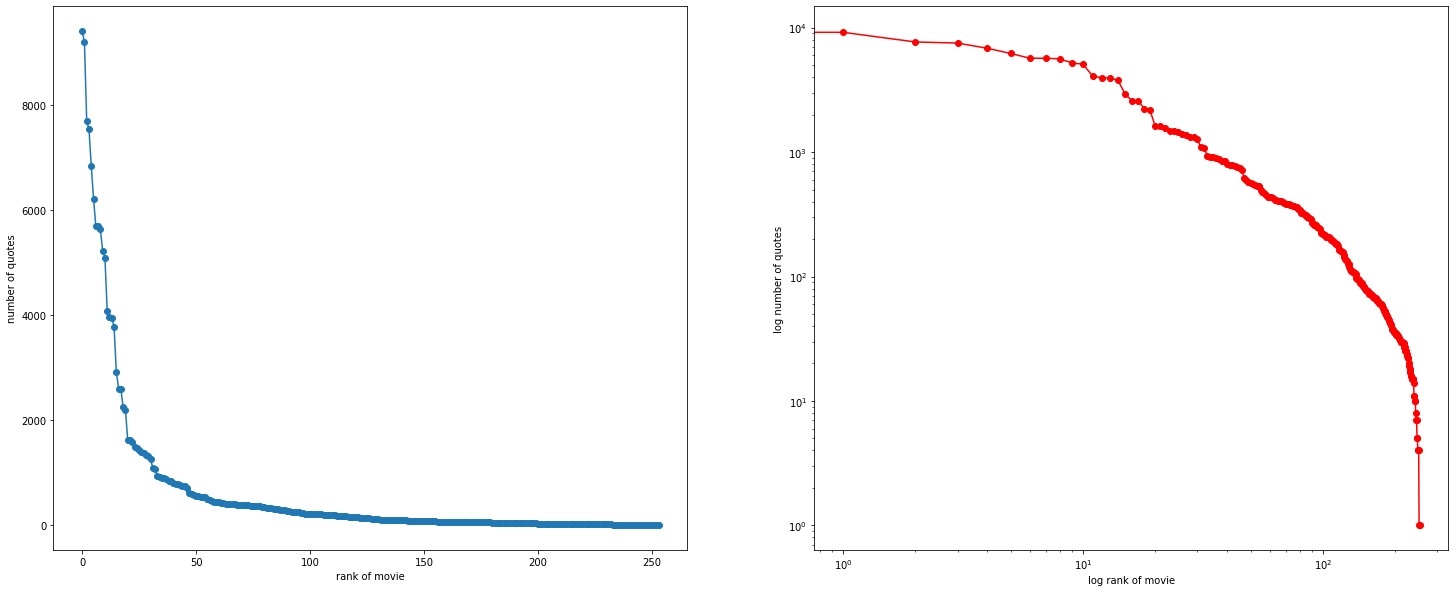

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,10)) # here we should decide a split (0-50 vs 50-100?)
ax[0].plot(quotes_by_movies.values(), marker='o')
ax[0].set_ylabel('number of quotes')
ax[0].set_xlabel('rank of movie')
ax[1].loglog(quotes_by_movies.values(), marker='o', color='red')
ax[1].set_ylabel('log number of quotes')
ax[1].set_xlabel('log rank of movie')

We sort the movies by number of quotes and visualize the distribution. It looks like a power low, but if we change to log-log axes, we can see it is clearly not a straight line.

Now we megre the information about quotes into our *movies_df* dataframe.

In [11]:
numOccurrences = pd.DataFrame()
numOccurrences['original_title'] = quotes_by_movies.keys()
numOccurrences['number_of_quotes'] = quotes_by_movies.values()
movies_df= pd.merge(movies_df,numOccurrences, how='left', on='original_title') 
movies_df

,original_title,usa_gross_income,year,number_of_quotes
0,Star Wars: Episode VII - The Force Awakens,936662225,2015,6837.0
1,Jurassic World,652270625,2015,389.0
2,Avengers: Age of Ultron,459005868,2015,1493.0
3,Inside Out,356921711,2015,187.0
4,Fast & Furious 7,353007020,2015,29.0
...,...,...,...,...
270,The Rhythm Section,5437971,2020,10.0
271,The Tax Collector,942666,2020,1.0
272,Cut Throat City,507436,2020,NaN
273,Wendy,143518,2020,NaN


---

## Proposed method: 
## 1.1 Linear regression between total number of quotes on a movie and domestic box office revenue <a class="anchor" id="chapter11"></a>

We run a linear regression to investigate whether more popular movies tend to have higher media coverage or not. We use statsmodels ols function to do so.

In [12]:
res = smf.ols(formula='usa_gross_income ~ number_of_quotes', data=movies_df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       usa_gross_income   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     132.6
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           6.25e-25
Time:                        21:15:43   Log-Likelihood:                -5081.7
No. Observations:                 254   AIC:                         1.017e+04
Df Residuals:                     252   BIC:                         1.017e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.242e+08   8.12e+06  

We conclude that the predictor *number_of_quotes* is indeed significant, since its small p-value. So in general the more successful a movie, the more media coverage it gets. 

<AxesSubplot:title={'center':'Number of quotes vs worldwide income of selected movies per year'}, xlabel='usa_gross_income', ylabel='number_of_quotes'>

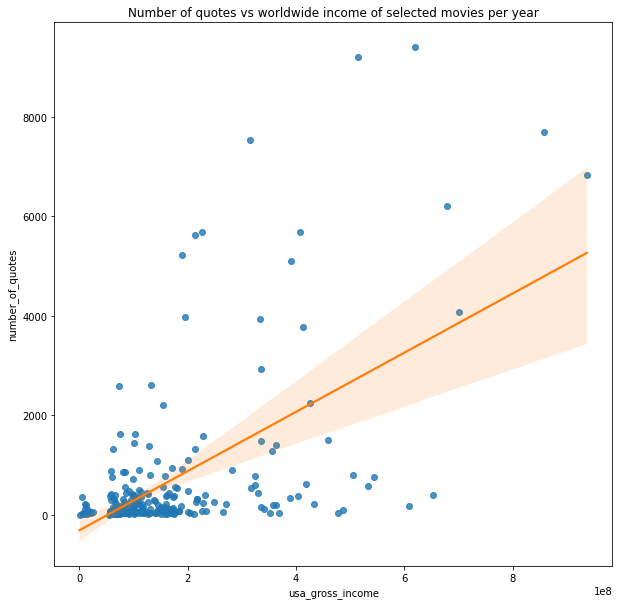

In [13]:
plt.figure(figsize = (10,10))
plt.title('Number of quotes vs worldwide income of selected movies per year')
sns.regplot(data=movies_df, x='usa_gross_income', y='number_of_quotes', line_kws = {'color': 'C1'})

---

## Proposed Method:
## 1.2. Observational study with propensity score matching <a class="anchor" id="chapter12"></a>

We calculate propensity score with logistic regression, based on movie attributes on IMDb data on few quote vs many quote movies and compare the results with box office data.

We will add the following features from the IMDb dataset: *avg_vote*, *budget*, *duration*, *metascore*, *votes*. Furthermore, we create a *genres* one hot feature as well.

In [14]:
movies_df = movies_df.merge(imdb[['original_title', 'avg_vote', 'budget','duration', 'metascore', 'votes','genre']], how='left', on='original_title')
movies_df

,original_title,usa_gross_income,year,number_of_quotes,avg_vote,budget,duration,metascore,votes,genre
0,Star Wars: Episode VII - The Force Awakens,936662225,2015,6837.0,7.9,245000000,138,80.0,845102,"Action, Adventure, Sci-Fi"
1,Jurassic World,652270625,2015,389.0,7.0,150000000,124,59.0,569512,"Action, Adventure, Sci-Fi"
2,Avengers: Age of Ultron,459005868,2015,1493.0,7.3,250000000,141,66.0,722685,"Action, Adventure, Sci-Fi"
3,Inside Out,356921711,2015,187.0,8.1,175000000,95,94.0,592575,"Animation, Adventure, Comedy"
4,Fast & Furious 7,353007020,2015,29.0,7.1,190000000,137,67.0,353562,"Action, Adventure, Thriller"
...,...,...,...,...,...,...,...,...,...,...
270,The Rhythm Section,5437971,2020,10.0,5.2,50000000,109,45.0,8816,"Action, Drama, Mystery"
271,The Tax Collector,942666,2020,1.0,4.7,30000000,95,22.0,4862,"Action, Crime, Drama"
272,Cut Throat City,507436,2020,NaN,4.3,8000000,123,67.0,141,"Action, Crime, Drama"
273,Wendy,143518,2020,NaN,5.7,6000000,111,54.0,1405,"Drama, Fantasy"


We transform our continous variable **number_of_quotes** into a cathegorical one, we chose a threshold for $500$ (approx $20\%$ of the data), if a movie has more quotes than the threshold, we cathegorize it as highly_quoted, denoted with the dummy variable **highly_quoted**.

In [15]:
movies_df['highly_quoted'] = 0
threshold = 500 #this might have to be bigger
movies_df.loc[movies_df['number_of_quotes']> threshold, 'highly_quoted'] = 1

In order to calculate propensity scores, we perform a logisitc regression using the statsmodel library. We want to study whether the number of quotes on a movie will have an effect on its performance in the box office, so we will regress the cathegoricl variable *highly_quoted* against covariates from the IMDb dataset. Note, that we do not include *usa_gross_income* as covariate, since this is our target variable, in the end we are interested the effect on this variabe.

In [16]:
import statsmodels.api as sm
columns = list(set(list(movies_df.columns)) - set(['original_title','usa_gross_income', 'number_of_quotes','highly_quoted', 'genre']))
mod = sm.Logit(movies_df['highly_quoted'], movies_df[columns])

res = mod.fit()

# Extract the estimated propensity scores
movies_df['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.364218
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          highly_quoted   No. Observations:                  275
Model:                          Logit   Df Residuals:                      269
Method:                           MLE   Df Model:                            5
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:                  0.2721
Time:                        21:15:51   Log-Likelihood:                -100.16
converged:                       True   LL-Null:                       -137.61
Covariance Type:            nonrobust   LLR p-value:                 9.755e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
votes       5.118e-06   1.34e-06      3.817      0.000    2.49e-06    7.75e-06
year          -0.0017      0.

<AxesSubplot:>

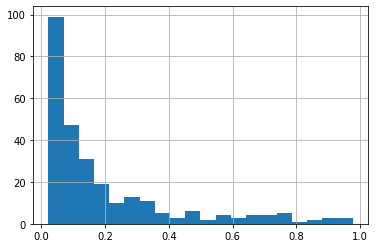

In [17]:
movies_df['Propensity_score'].hist(bins=20)

In [18]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

Based on the propensity score we calculate similarity between the two gropus and make a bipartite graph. The edge weight between two nodes are the similarity scores. We want to find a maximal weight matching between the two groups (**highly_quoted** and **lowly_quoted**). The matching is found using the Hungarian algorithm, the graph is stored in a **networkx** object.

In [19]:
# Separate the treatment and control groups
highly_quoted_df = movies_df[movies_df['highly_quoted'] == 1]
lowly_quoted_df = movies_df[movies_df['highly_quoted'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for l_id, l_row in lowly_quoted_df.iterrows():
    for h_id, h_row in highly_quoted_df.iterrows():

        similarity = get_similarity(l_row['Propensity_score'],h_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(l_id, h_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

# Make a 'mask' of the indexes of the matched movies
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

Now we have a matching, it's time to check the means and the distributions of our filtered data.

In [20]:
balanced_df = movies_df.loc[matched]
balanced_highly_quoted_df = balanced_df[balanced_df['highly_quoted'] == 1]
balanced_lowly_quoted_df = balanced_df[balanced_df['highly_quoted'] == 0]

We check the propensity scores, now it seems more balanced compared to the previous plot.

<AxesSubplot:>

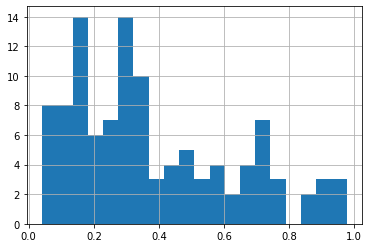

In [21]:
balanced_df['Propensity_score'].hist(bins=20)

In [22]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [23]:
high_CI = bootstrap_CI(balanced_highly_quoted_df['usa_gross_income'], 1000)
low_CI = bootstrap_CI(balanced_lowly_quoted_df['usa_gross_income'], 1000)
high_mean = balanced_highly_quoted_df['usa_gross_income'].mean()
low_mean = balanced_lowly_quoted_df['usa_gross_income'].mean()

print(f'mean usa gross income on highly quotes moves: {high_mean},    95%-CI: {high_CI} ')
print(f'mean usa gross income on lowly quotes moves: {low_mean},     95%-CI:  {low_CI}')

mean usa gross income on highly quotes moves: 288705109.74545455,    95%-CI: [237597510.05772728, 343081377.39772725] 
mean usa gross income on lowly quotes moves: 206249748.6,     95%-CI:  [173494284.135, 245194051.00954545]


In [24]:
stats.ttest_ind(balanced_highly_quoted_df['usa_gross_income'], balanced_lowly_quoted_df['usa_gross_income'], equal_var=False)

Ttest_indResult(statistic=2.492717014276856, pvalue=0.0144448363191324)

More quoted movies have higher mean gross income, the t-test and the confidence intervals point out they do differ significantly, we conclude that quotes have a significant positive effect on the gross income.

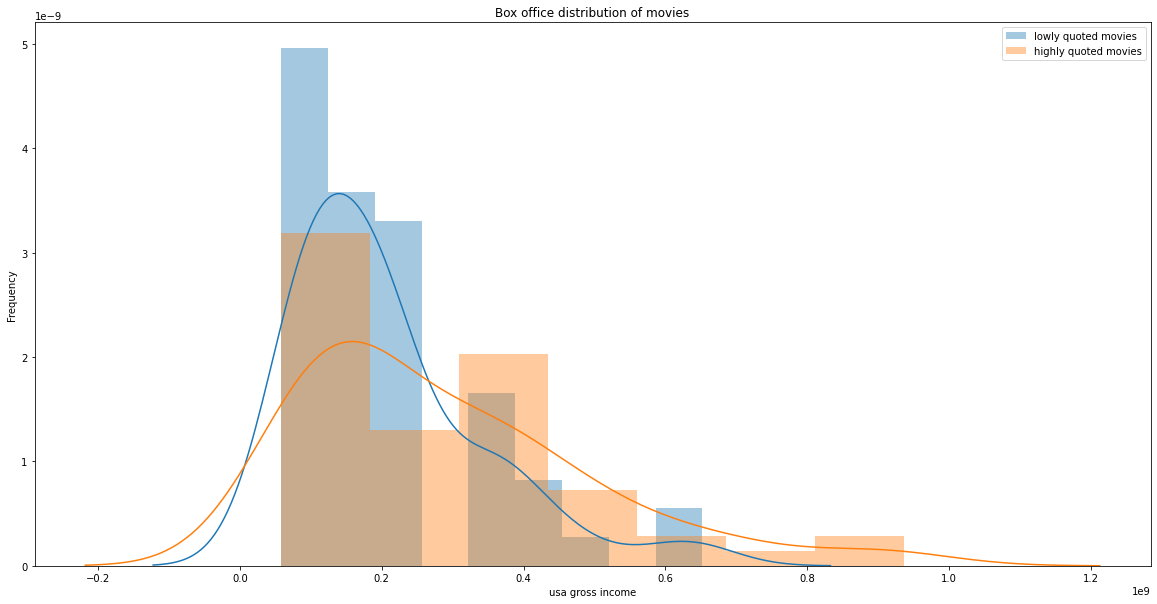

In [25]:
fig, ax = plt.subplots(figsize =(20,10))
sns.distplot(balanced_lowly_quoted_df['usa_gross_income'], hist=True, label='lowly quoted movies', ax=ax)
sns.distplot(balanced_highly_quoted_df['usa_gross_income'], hist=True, label='highly quoted movies', ax=ax)
ax.set(title='Box office distribution of movies',xlabel='usa gross income', ylabel='Frequency')
plt.legend()
plt.show()

Finally we investigate if the samples are from the same distribution. We make a QQ plot and a Kolmogorov-Smirnoff test

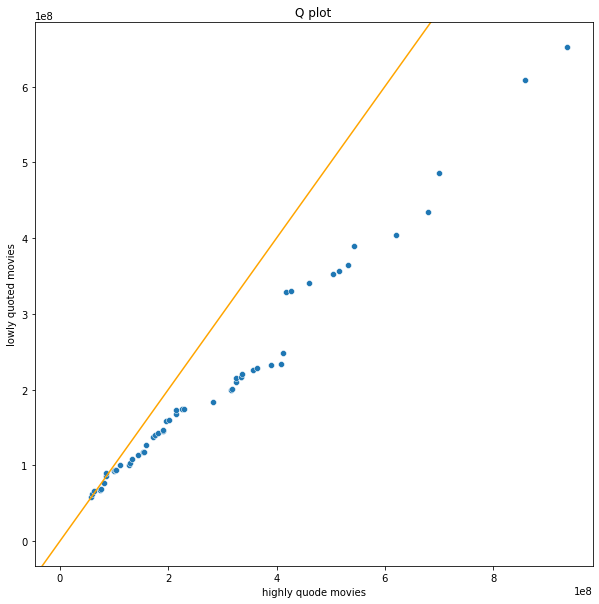

In [38]:
high = np.sort(balanced_highly_quoted_df['usa_gross_income'])
low = np.sort(balanced_lowly_quoted_df['usa_gross_income'])

fig, ax = plt.subplots(figsize =(10,10))
sns.scatterplot(high, low, ax=ax)
ax.set(xlabel="highly quode movies", ylabel="lowly quoted movies", title="Q plot")
ax.axline((1, 1), slope=1, color='orange') 


In [37]:
kstest(balanced_lowly_quoted_df['usa_gross_income'],balanced_highly_quoted_df['usa_gross_income'])


KstestResult(statistic=0.23636363636363636, pvalue=0.09251790142202007)

Even though the QQ plot suggest otherwise, we cannot reject the null hypothesis that the two samples came from the same distribution.

---

# RQ2: An Investigation into Time Series Box Office and Quotes in a Few Movies <a class="anchor" id="chapter2"></a>

## Proposed method: 
## 2.1. Initial analysis and Kolmogorov-Smirnov test <a class="anchor" id="chapter21"></a>

In this section, we will investigate the relationship between the boxOffice dataset and the Quotes in X movies.

In [85]:
#Load in the boxOffice dataset
filename = f"boxOffice"
data_dir = os.getcwd() + os.sep + 'exploratory' + os.sep + 'data'

df_boxOffice = pd.read_pickle(rf"{data_dir}{os.sep}{filename}.pkl")

quotes = pd.read_pickle('./exploratory/data/Quotebank_sentiment.pkl')
quotes['date'] = pd.to_datetime(quotes['date'])

To figure out which movies to use, we found that movies with few quotes were too boring. Below there is an example with Dolittle

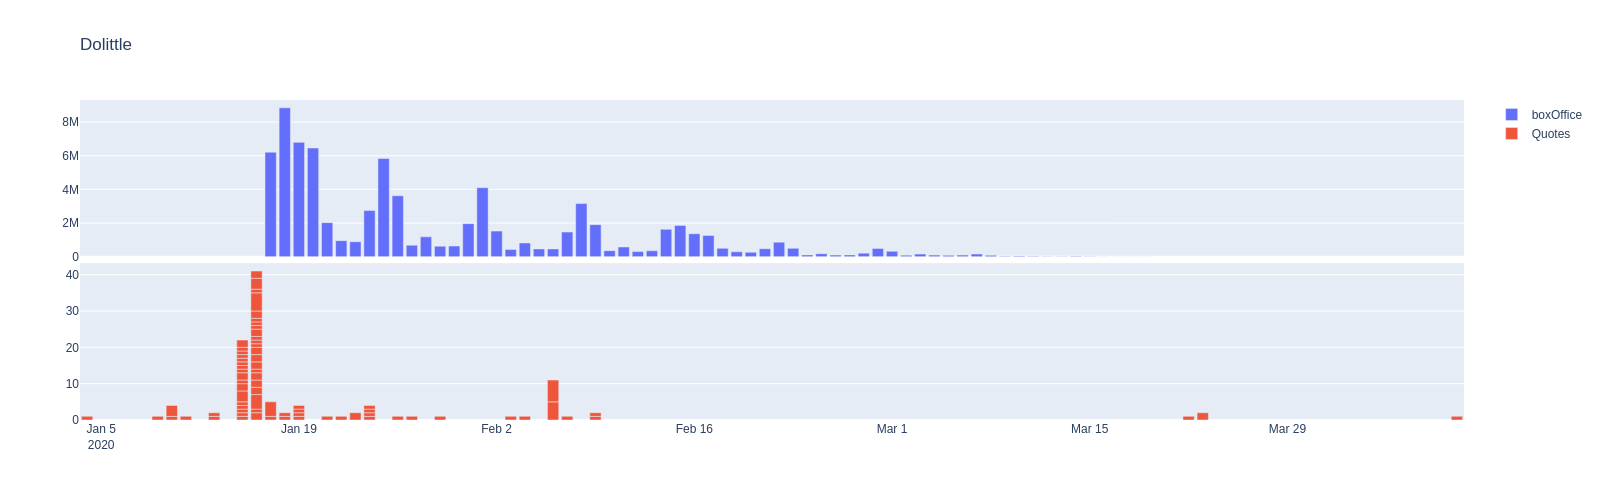

In [86]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.02)

fig.append_trace(go.Bar(x=df_boxOffice[df_boxOffice.movie=='Dolittle'].days, y = df_boxOffice[df_boxOffice.movie=='Dolittle'].daily, name='boxOffice'), row=1, col=1)
fig.append_trace(go.Bar(x=quotes[quotes.movie=='Dolittle'].date, y = quotes[quotes.movie=='Dolittle'].numOccurrences, name = 'Quotes'), row=2, col=1)
fig.update_layout(title_text="Dolittle")
fig.update_layout(width=1600, height=500)
fig.show('png')

Instead we decided to take the three most quoted movies. The cell below shows how we sorted the movies:

In [87]:
movies, freq_unsorted = np.unique(quotes.movie, return_counts=True)
freq, movies = np.array(list(zip(*sorted(zip(freq_unsorted, movies), reverse=True))))

print("Three top quoted movies: ")
list(zip(movies, freq))[:3]

Three top quoted movies: 


[('Star Wars: Episode VIII - The Last Jedi', '8368'),
 ('Star Wars: Episode VII - The Force Awakens', '7812'),
 ('Thor: Ragnarok', '6849')]

There you have it. We will do similar plots to the one above with Dolittle, however, we will only plot the period in which the movies were in theaters. This will come in handy when we test the distributions. The cells below will filter the data and plot it:

In [88]:
#Get the min and max day for all three films
min_day_sw_VIII = list(df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VIII - The Last Jedi'].days)[0]
max_day_sw_VIII = list(df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VIII - The Last Jedi'].days)[-1]

min_day_sw_VII = list(df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VII - The Force Awakens'].days)[0]
max_day_sw_VII = list(df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VII - The Force Awakens'].days)[-1]

min_day_thor = list(df_boxOffice[df_boxOffice.movie=='Thor: Ragnarok'].days)[0]
max_day_thor = list(df_boxOffice[df_boxOffice.movie=='Thor: Ragnarok'].days)[-1]

#Define new dataframes, where we can drop all quotes outside of our scope
sw_VIII = quotes[quotes.movie=='Star Wars: Episode VIII - The Last Jedi']
sw_VII = quotes[quotes.movie=='Star Wars: Episode VII - The Force Awakens']
thor = quotes[quotes.movie=='Thor: Ragnarok']

#Drop all quotes outside of our time periods:
sw_VIII=sw_VIII[sw_VIII.date>=min_day_sw_VIII]
sw_VIII=sw_VIII[sw_VIII.date<=max_day_sw_VIII]

sw_VII=sw_VII[sw_VII.date>=min_day_sw_VII]
sw_VII=sw_VII[sw_VII.date<=max_day_sw_VII]

thor=thor[thor.date>=min_day_thor]
thor=thor[thor.date<=max_day_thor]

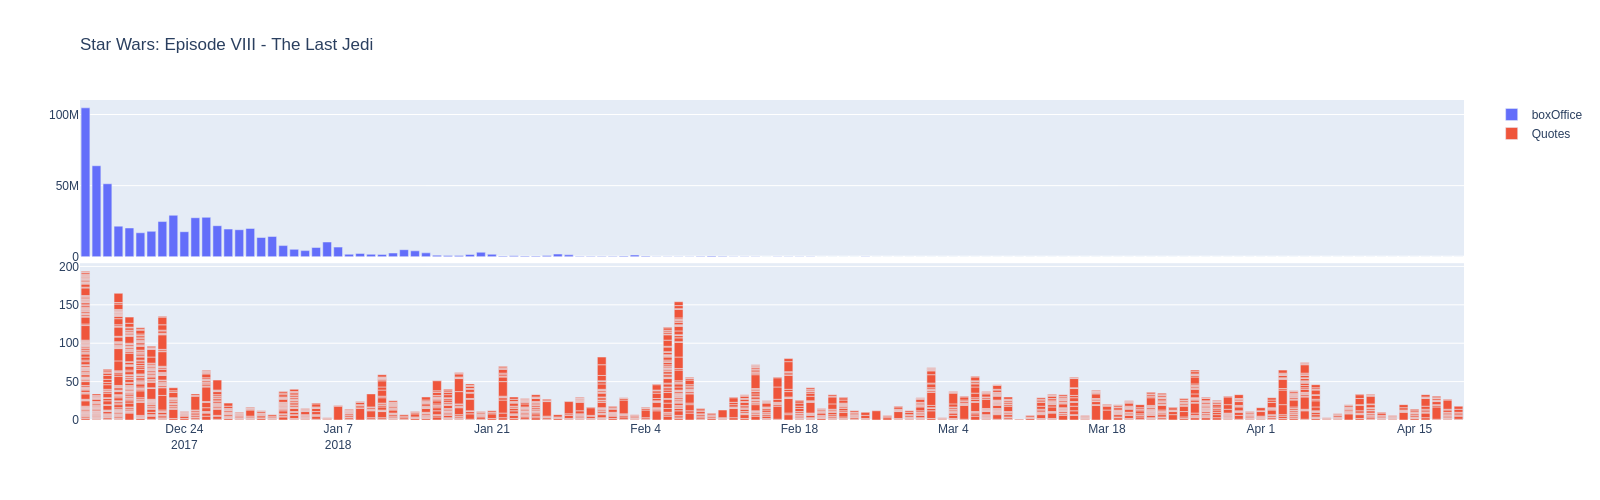

In [89]:
#Star Wars: Episode VIII - The Last Jedi:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.02)

fig.append_trace(go.Bar(x=df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VIII - The Last Jedi'].days, y = df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VIII - The Last Jedi'].daily, name='boxOffice'), row=1, col=1)
fig.append_trace(go.Bar(x=sw_VIII.date, y = sw_VIII.numOccurrences, name = 'Quotes'), row=2, col=1)
fig.update_layout(title_text="Star Wars: Episode VIII - The Last Jedi")
fig.update_layout(width=1600, height=500)
fig.show('png')

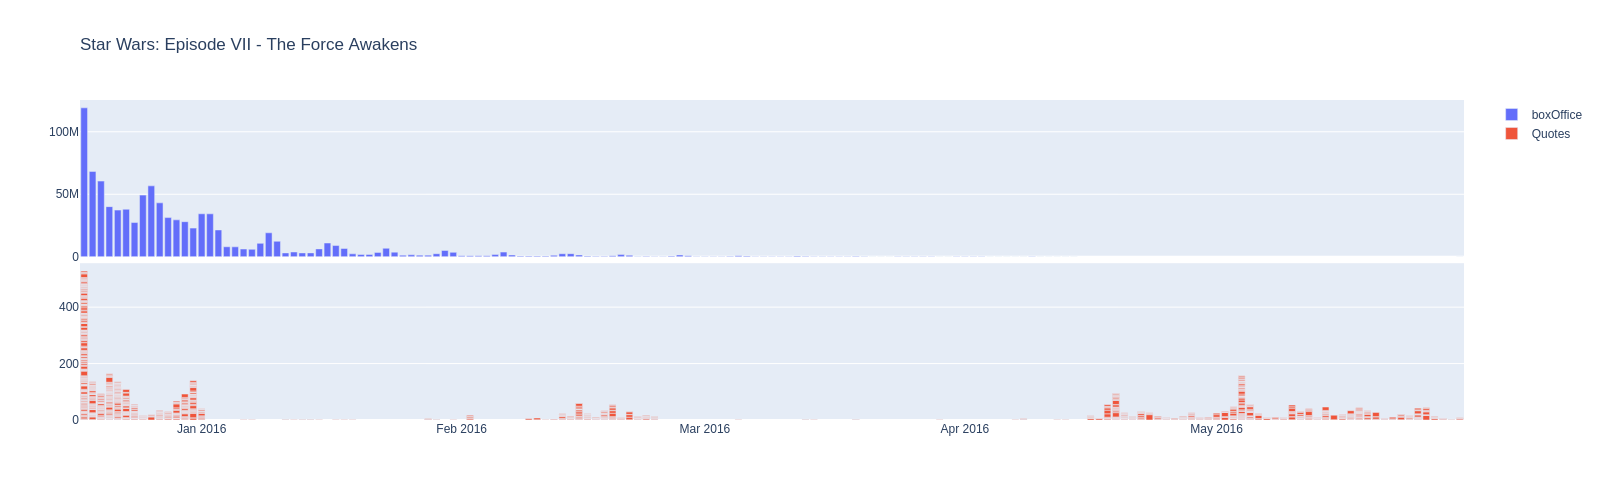

In [90]:
#Star Wars: Episode VII - The Force Awakens
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.02)

fig.append_trace(go.Bar(x=df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VII - The Force Awakens'].days, y = df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VII - The Force Awakens'].daily, name='boxOffice'), row=1, col=1)
fig.append_trace(go.Bar(x=sw_VII.date, y = sw_VII.numOccurrences, name = 'Quotes'), row=2, col=1)
fig.update_layout(title_text="Star Wars: Episode VII - The Force Awakens")
fig.update_layout(width=1600, height=500)
fig.update_layout( width=1600, height=500)
fig.show('png')

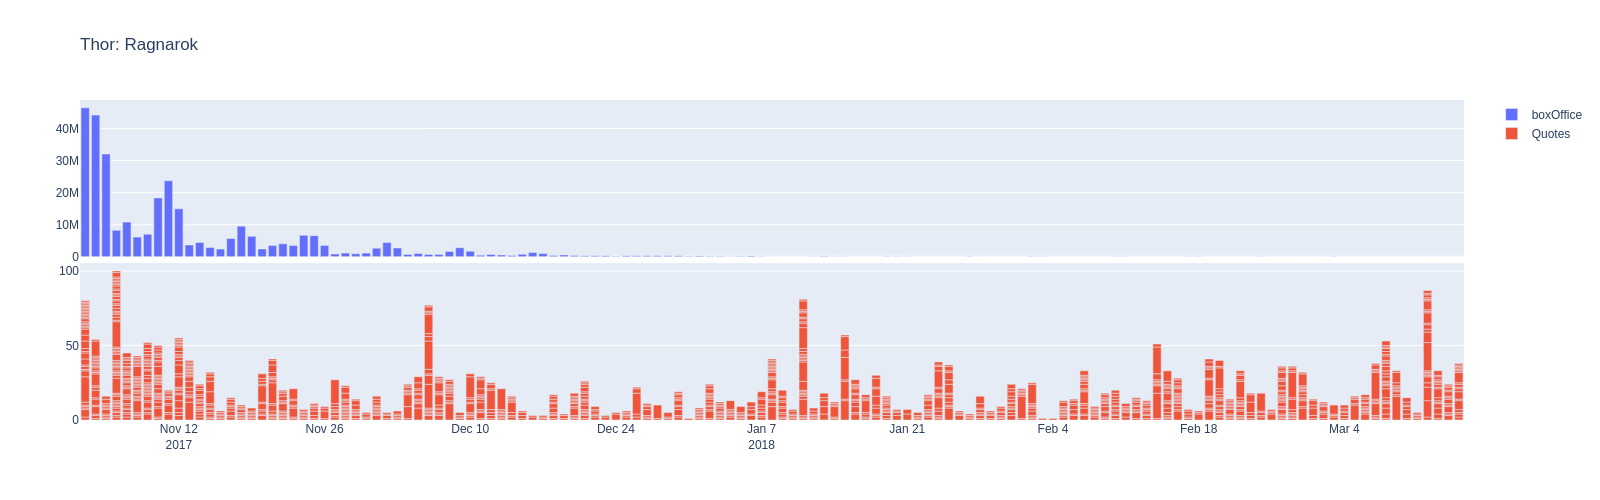

In [91]:
#Thor: Ragnarok
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.02)

fig.append_trace(go.Bar(x=df_boxOffice[df_boxOffice.movie=='Thor: Ragnarok'].days, y = df_boxOffice[df_boxOffice.movie=='Thor: Ragnarok'].daily, name='boxOffice'), row=1, col=1)
fig.append_trace(go.Bar(x=thor.date, y = thor.numOccurrences, name = 'Quotes'), row=2, col=1)
fig.update_layout(title_text="Thor: Ragnarok")
fig.update_layout( width=1600, height=500)
fig.show('png')

It does not look like there is a relationship between the boxOffice and quotes, but let's test it! We start by scaling everything into the range [0,1]. This is done in the next cell:

In [92]:
sw_VIII_box = df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VII - The Force Awakens'].daily
sw_VII_box = df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VIII - The Last Jedi'].daily
thor_box = sw_VIII_box = df_boxOffice[df_boxOffice.movie=='Thor: Ragnarok'].daily

sw_VIII_box = list((sw_VIII_box - sw_VIII_box.min()) / (sw_VIII_box.max() - sw_VIII_box.min()))
sw_VII_box = list((sw_VII_box - sw_VII_box.min()) / (sw_VII_box.max() - sw_VII_box.min()))
thor_box = list((thor_box - thor_box.min()) / (thor_box.max() - thor_box.min()))

sw_VIII = sw_VIII.groupby('date').numOccurrences.sum()
sw_VII = sw_VII.groupby('date').numOccurrences.sum()
thor = thor.groupby('date').numOccurrences.sum()

sw_VIII_quotes = list((sw_VIII - sw_VIII.min()) / (sw_VIII.max() - sw_VIII.min()))
sw_VII_quotes = list((sw_VII - sw_VII.min()) / (sw_VII.max() - sw_VII.min()))
thor_quotes = list((thor - thor.min()) / (thor.max() - thor.min()))

Now we can do some testing. We chose to use the Kolmogorov-Smirnov test (kstest). All parameters are set to default as it works well in our case:

In [93]:
sw_VII_stat, sw_VII_p = kstest(sw_VII_box,sw_VII_quotes)
print('Star Wars: Episode VII - The Force Awakens:\nks-stat: ',sw_VII_stat,'\np-value: ', sw_VII_p,'\n')

sw_VIII_stat, sw_VIII_p = kstest(sw_VIII_box,sw_VIII_quotes)
print('Star Wars: Episode VIII - The Last Jedi:\nks-stat: ',sw_VIII_stat,'\np-value: ', sw_VIII_p,'\n')

thor_stat, thor_p = kstest(thor_box,thor_quotes)
print('Thor: Ragnarok:\nks-stat: ',thor_stat,'\np-value: ', thor_p)

Star Wars: Episode VII - The Force Awakens:
ks-stat:  0.41774891774891776 
p-value:  3.341567245129795e-09 

Star Wars: Episode VIII - The Last Jedi:
ks-stat:  0.7351712614870509 
p-value:  8.881784197001252e-16 

Thor: Ragnarok:
ks-stat:  0.7293233082706767 
p-value:  1.5328238282581075e-34


We will reject all the null-hypothesises (that the distributions for quotes and boxOffice was identical) because of the low p-values (lower than .05, the default alpha). Therefore, we cannot say that the number of quotes about one of the three movies on a given day can influence (or be influenced by) the boxOffice of said movie on that given day.

---

## Proposed method: 
## 3.2. Checking correlation between distribution of quotes over time and box office time series data <a class="anchor" id="chapter22"></a>

We are interested in whetehr the time series of quotes and time series of box office relate to each other in some sense. Firts, ee will transform the time series to become stationary. Then we propose two models:
- We fit a VAR (Vector autoregression) model on the data and check the correlation of the residuals.
- We perform a Granger Causality test 

For this question we only consider one choses movie, our choice is Avengers: Infinity War.

Analyisis based on this blog post https://towardsdatascience.com/a-quick-introduction-on-granger-causality-testing-for-time-series-analysis-7113dc9420d2.

In [94]:
movie_title = "Avengers: Infinity War"
movie_title = movie_title.replace(" ", "_")
movie_title = movie_title.replace("-", "_")
movie_title = movie_title.replace(":", "")
movie_title

'Avengers_Infinity_War'

In [95]:
title = "Avengers: Infinity War"
time_series = quotes[quotes['movie'] == title].groupby(['date'],  as_index=False).count()[['date', 'quotation']]

In [96]:
bo = pd.read_csv('./exploratory/data/time_series_box_office_data/Avengers_Infinity_War___Box_Office_Mojo.csv')
bo = bo.rename(columns={'days': 'date'})
bo['date'] = pd.to_datetime(bo['date'])
bo = bo[['date','daily']]
time_series = time_series.merge(bo, how='left', on='date')
time_series = time_series.dropna()

<AxesSubplot:xlabel='date', ylabel='daily'>

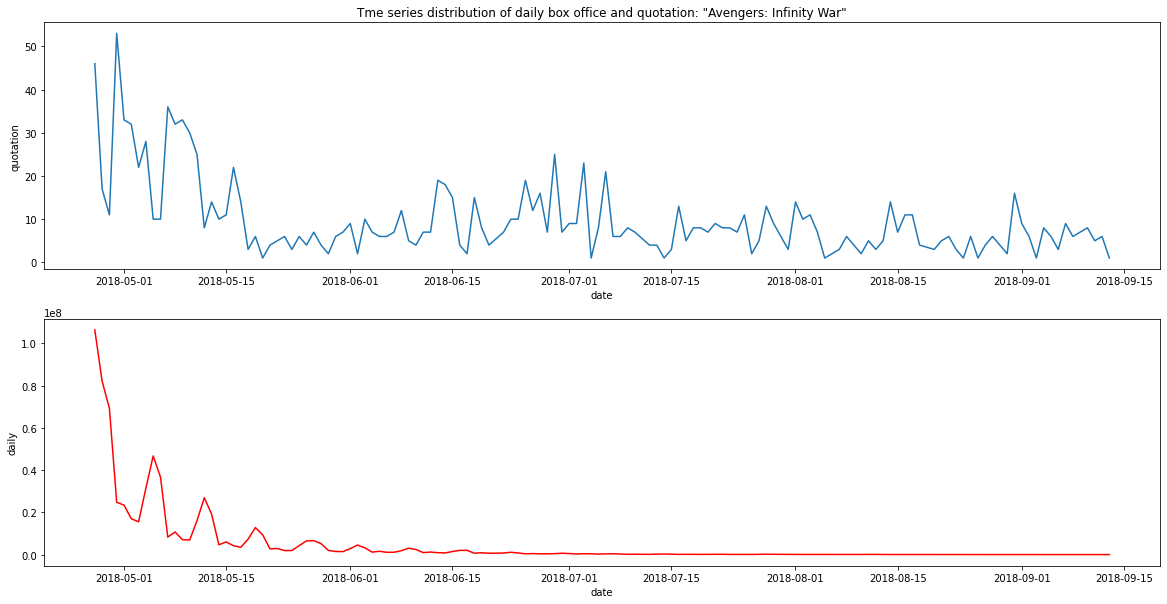

In [97]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,10))
ax[0].set(title='Tme series distribution of daily box office and quotation: "Avengers: Infinity War"')
sns.lineplot(x='date', y='quotation', data=time_series, ax=ax[0])
sns.lineplot(x='date', y='daily', data=time_series, ax=ax[1], color='red')

We use an ADF test to determine whether the underlying time series are stationary or not. Null hypothesis: it suggests the time series is not stationarity (if failed to be rejected)

In [98]:
result = adfuller(time_series['quotation'].values)
print(f'ADF Statistics for quotation: {result[0]}')
print(f'p-value: {result[1]}')

result = adfuller(time_series['daily'].values)
print(f'ADF Statistics for box office: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistics for quotation: -4.055861258289217
p-value: 0.001144657257171167
ADF Statistics for box office: -4.981642171850192
p-value: 2.4126634872146793e-05


Small p values suggest that the time series are stationary. We will note that this is likely because of the long tails of the two time series, at the premier of the movie there is clearly a peak at both cases. We will try to get rid of this minor issue and transform our time series with the difference method. It can be used to remove the series dependence on time, so-called temporal dependence.

<AxesSubplot:xlabel='date', ylabel='diff_daily'>

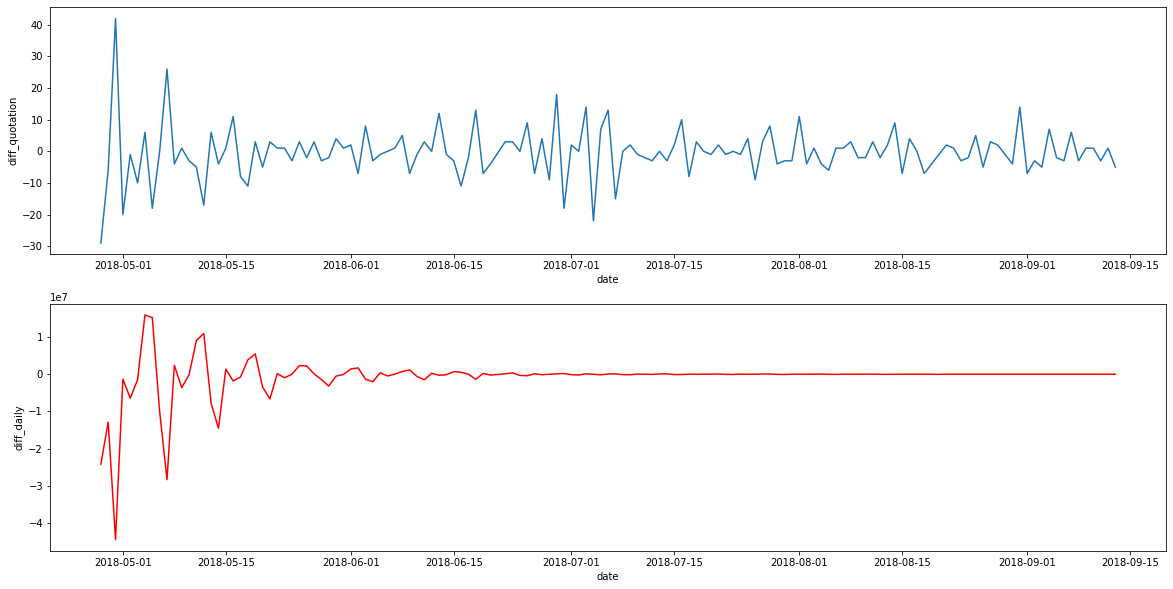

In [99]:
time_series['diff_quotation'] = time_series['quotation'].diff()
time_series['diff_daily'] = time_series['daily'].diff()

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,10))
sns.lineplot(x='date', y='diff_quotation', data=time_series, ax=ax[0])
sns.lineplot(x='date', y='diff_daily', data=time_series, ax=ax[1], color='red')


We will do the ADF tests just to be sure.

In [100]:
time_series = time_series.dropna()
result = adfuller(time_series['diff_quotation'].values)
print(f'ADF Statistics for quotation: {result[0]}')
print(f'p-value: {result[1]}')

result = adfuller(time_series['diff_daily'].values)
print(f'ADF Statistics for box office: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistics for quotation: -9.37547729509302
p-value: 7.186865372345419e-16
ADF Statistics for box office: -3.547067774241008
p-value: 0.006857445486581326


The plots and the p-values suggest that we eliminated the time dependency. We will move on to check correlations.

We will use the VAR model fist (Vector autoregression). The VAR class assumes that the passed time series are stationary.

A VAR model describes the evolution of a set of $k$ variables, over time. The variables are collected in a vector, $y_t$, which is of length $k$. The vector is modelled as a linear function of its previous value. The last term is the error term. $$y_t = A_1 y_{t-1} + A_2 y_{t-2} +... A_{p} y_{t-p} + \epsilon$$

We will try models with different lags, The best model will be selected by the minimum AIC score. If we have a model with $k$ parameters, and $L$ is the maximum value of the likelihood function for the model then the AIC score is given by: $AIC = 2k - 2 log(L)$

In [101]:
#time_series = time_series.set_index('date')
def best_lag_by_aic(data):
    model = VAR(data)
    AIC = []
    for i in range(0,15):
        result = model.fit(i)
        AIC.append(result.aic)
    return np.argmin(AIC)

best = best_lag_by_aic(time_series[['diff_daily', 'diff_quotation']])
print(f' Best model: {best}')

 Best model: 11


In [102]:
model = VAR(time_series[['diff_daily', 'diff_quotation']])
results = model.fit(maxlags=11, ic='aic')
results.resid_corr

array([[ 1.        , -0.05743393],
       [-0.05743393,  1.        ]])

The residual errors of the VAR model suggests that the the two time series are not correlated.

## Granger Causality 

Now we perform a Granger Causality Test. The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another. We say that a variable $X$ that evolves over time Granger-causes another evolving variable $Y$ if predictions of the value of $Y$ based on its own past values and on the past values of $X$ are better than predictions of $Y$ based only on $Y$'s own past values.

Formally let $\mathcal{F}(t)$ be the filtration w.r.t. $X$ and $Y$ and let $\mathcal{G}(t)$ be the sub-filtration w.r.t. only $Y$. ($\mathcal{F}(t)$ has more information than $\mathcal{G}(t)$). We want to test the hypothesis that $\mathcal{P}(Y(t+1)\in A| \mathcal{F}(t)) \neq \mathcal{P}(X(t+1)\in A | \mathcal{G}(t))$ for arbitrary measurable set $A$.

In practise we undertake the following steps:
- fit a VAR model to $Y$, that is $y_t=\sum a_i y_{t-i} + \epsilon$
- fit a second VAR model to $Y$ using the information from $X$ as well $y_t =\sum a_i y_{t-i} + \epsilon + \sum b_j x_{t-j} $
- Test the null hypothesis that the coefficients corresponding to past values of the second time series are zero. (We will use chi2 test to do so, another popular option is to use a series of t and F tests)
- We reject the the null hypothesis if there exists a significant predictor, in this case we say that $X$ Granger causes $Y$.

In [103]:
maxlag=11
test = 'ssr_chi2test'
def grangers_causation(data, test='ssr_chi2test', maxlag=maxlag):    
    test_result = grangercausalitytests(data, maxlag=maxlag, verbose=False)
    p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
    min_p_value = np.min(p_values)
    #params = test_result[np.argmin(p_values) + 1][1][1].params
    return min_p_value

test_result = grangers_causation(time_series[['diff_daily', 'diff_quotation']], test=test, maxlag=maxlag)
test_result

0.0

We can reject the null hypothesis and conclude that diff_daily_x Granger causes diff_quotation_y. On the other hand diff_daily_y Granger causes diff_quotation_x. All the time series in the above data are interchangeably Granger causing each other.

Now let's make a helper function from the above steps and do the analysis for all the movies we have.

In [104]:
def time_series_granger_pipeline(titles):
    cause_box = {}
    for i, title in enumerate(titles):
        try:
            #load quotations
            time_series = quotes[quotes['movie'] == title].groupby(['date'],  as_index=False).count()[['date', 'quotation']]

            #load box office
            bo = df_boxOffice[df_boxOffice['movie']==title]
            bo = bo.rename(columns={'days': 'date'})
            bo['date'] = pd.to_datetime(bo['date'])
            bo = bo[['date','daily']]
            time_series = time_series.merge(bo, how='left', on='date')
            time_series = time_series.dropna()

            #transforming into stationary time series
            time_series['diff_quotation'] = time_series['quotation'].diff() 
            time_series['diff_daily'] = time_series['daily'].diff()
            time_series = time_series.dropna()
            
            #choosing the best lag for Vector Autoregression by AIC score
            maxlag = best_lag_by_aic(time_series[['diff_daily', 'diff_quotation']])
            
            gcm = grangers_causation(time_series[['diff_daily', 'diff_quotation']], test='ssr_chi2test', maxlag=maxlag)
            cause_box[title] = (gcm, gcm < 0.05)
        except:
            pass
       
    return cause_box

In [105]:
titles = list(quotes['movie'].unique())
cause_box = time_series_granger_pipeline(titles)

Finally we plot the results. We are interested in whether the daily number of quotes Granger causes the box office sales.

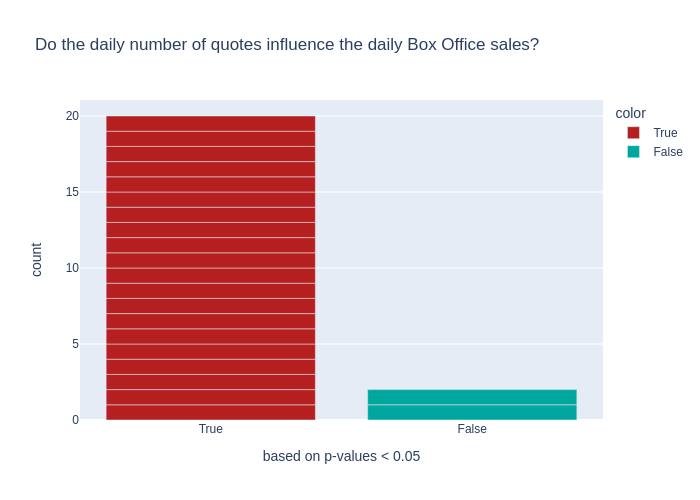

In [106]:
import plotly.express as px

sent2box = np.array([(movie, p_val, reject) for movie, (p_val, reject) in cause_box.items()])
temp = pd.DataFrame(sent2box).rename(columns={0: 'movie', 1: 'p_vals', 2: 'reject'})

fig = px.bar(x=temp.reject, y=(np.ones(len(temp.reject))), labels={'x':'based on p-values < 0.05', 'y':'count'},
            hover_name =temp.movie,
            color=temp.reject,
            color_discrete_sequence=['#B51F1F', '#00A79F'],
            title='Do the daily number of quotes influence the daily Box Office sales?')
fig.update_layout(width=700, height=500)
fig.show('png')

We will adjust the p-values with the Bonferroni method.

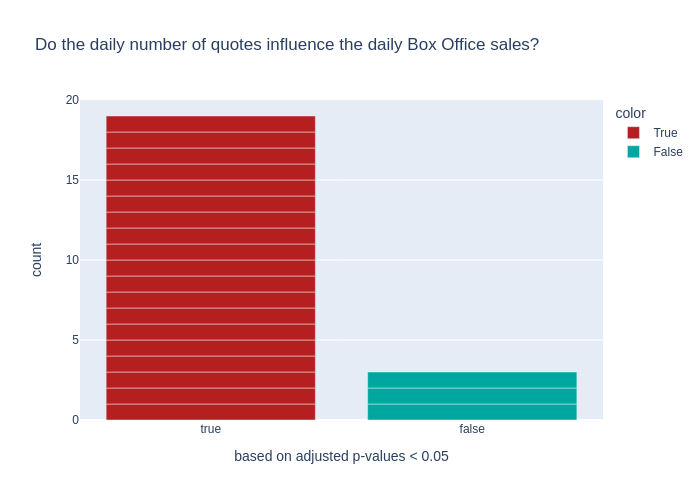

In [107]:
reject_sent2box, adj_pvals_sent2box, _, _ = multipletests(sent2box[:,1].astype(float), alpha=0.05, method='bonferroni')
adj_pvals_df = pd.DataFrame(adj_pvals_sent2box, reject_sent2box)
adj_pvals_df['movie'] = sent2box[:,0]
adj_pvals_df = adj_pvals_df.reset_index().rename(columns={0: 'p_vals', 'index': 'reject'})

fig = px.bar(x=adj_pvals_df.reject, y=(np.ones(len(adj_pvals_df.reject))), labels={'x':'based on adjusted p-values < 0.05', 'y':'count'},
            hover_name =adj_pvals_df.movie,
            color=adj_pvals_df.reject, #sent2box[:,0],
            color_discrete_sequence=['#B51F1F', '#00A79F'],
            title='Do the daily number of quotes influence the daily Box Office sales?')
fig.update_layout(width=700, height=500)
fig.show('png')

Conclusion: it seems that for most of the movies we can conclude Granger causality, which means in general big media coverage results with high box office revenue.

---

# RQ 3 - Sentiment, Ratings and Box Office  <a class="anchor" id="chapter3"></a>

Sentiment analysis in quotes about movies over time. Additionaly relate sentiment to Box Office sales and see if positive/negative media coverage affect the sale of tickets.        
- RQ3.1: Does the media/quoters opinion on a certain movie affect the amount of sold tickets?     
- RQ3.2: Does the sentiment seen in quotes relate to the rating on IMDB? 


## 3.1: Sentiment and Box Office  <a class="anchor" id="chapter31"></a>

We aim at investigating whether the sentiment related to movies can be seen as correlated to the Box Office revenue related to movies. To do this we first need to account for consistency between the Box Office and the Quotebank data sets. Below we change the days/date attribute to be consistent. Furthermore, as explained in the `Quotebank_sentiment.ipynb` notebook we will use the transformer based (BERT) sentiment score from `HuggingFace`. This score was saved in the Quotebank dataframe as the probability of being positive between 0 and 1 - this is now reexpressed on a scale between -1 and 1 for being able to express negative Quotes and have a better and more intuitive representation of negative sentiment.

In [108]:
# rename for consistency between data sets
df_Quotebank = df_Quotebank.rename(columns={'date': 'days'})

# re-express positive bert score for intuition of negative values
df_Quotebank['positive_BERT_score'] = 2 * (df_Quotebank.positive_BERT_score - 0.5)
df_Quotebank.positive_BERT_score

# attributes of interest
aoi = ['movie', 'days', 'BERT_label', 'multiplied_BERT', 'VADER_label', 'multiplied_VADER']

In [109]:
df_Quotebank['multiplied_VADER'] = df_Quotebank.numOccurrences * df_Quotebank.VADER_score
df_Quotebank['multiplied_BERT'] = df_Quotebank.numOccurrences * df_Quotebank.positive_BERT_score

### Multiplied daily sentiment
As the Box Office sales are the total revenue for the movie across all movie theaters we will follow a similar approach when considering the sentiment of quotes for this research sub-question. Thus, we will multiply the daily sentiment of a quote about a movie with its number of occurrences and sum this multiplied sentiment for all quotes occuring at each date related to a movie. This approach is similar to the Box Office for which reason we find them comparable. In research (sub)question 2.2 we will use a different approach that is better related to the IMDb data set.

In [110]:
multSum_per_day = df_Quotebank[aoi].groupby(['movie', 'days']).sum()
multSum_per_day.describe()

,multiplied_BERT,multiplied_VADER
count,12717.000000,12717.000000
mean,3.710182,1.582479
std,12.279737,7.717111
min,-158.377222,-187.232100
25%,-0.930393,-0.273200
50%,0.999746,0.773400
75%,4.982895,2.752100
max,430.519033,128.797100


In [111]:
multSum_per_day

multiplied_BERT  multiplied_VADER
movie    days                                         
Aladdin  2019-01-02         0.998775            0.9929
         2019-01-03         1.353582            0.2732
         2019-01-08         0.169957            0.5464
         2019-01-13         0.999398            0.8720
         2019-01-15         1.994038            0.9725
...                              ...               ...
Zootopia 2017-11-13        -0.965401            0.0000
         2017-12-07        -0.034033            0.0000
         2017-12-20         0.997421            0.6808
         2017-12-26         0.727826            0.4404
         2017-12-27        -0.997922            0.6880

[12717 rows x 2 columns]

We see that the summations seems to be correctly made but realize that there is much more data in the quotebank data than in the box office data. As we investigate whether the relation between sentiment of quotes correlate with the box office sales we restrict ourselves to the period for a movie determine by the airing time in the cinemas, such that we use all of the dates from the box office data but disregard quotes appearing after the movie was taken of the screen. We do this by creating a merged data frame.

In [112]:
merged_df = df_boxOffice.drop('special events', axis=1).merge(multSum_per_day, on=['movie', 'days'], how='left')
merged_df

,days,dow,rank,daily,theaters,movie,multiplied_BERT,multiplied_VADER
0,2019-05-24,Friday,1,31358935.0,4476,Aladdin,21.811739,16.0772
1,2019-05-25,Saturday,1,30013295.0,4476,Aladdin,3.891365,3.1421
2,2019-05-26,Sunday,1,30128699.0,4476,Aladdin,3.029213,0.7860
3,2019-05-27,Monday,1,25305033.0,4476,Aladdin,4.431028,-0.5205
4,2019-05-28,Tuesday,1,12014982.0,4476,Aladdin,19.273443,-6.4471
...,...,...,...,...,...,...,...,...
6900,2016-07-31,Sunday,43,2144.0,24,Zootopia,NaN,NaN
6901,2016-08-01,Monday,43,845.0,24,Zootopia,NaN,NaN
6902,2016-08-02,Tuesday,43,904.0,24,Zootopia,0.986622,0.7964
6903,2016-08-03,Wednesday,45,865.0,24,Zootopia,NaN,NaN


In [113]:
merged_df.isnull().any()

days                False
dow                 False
rank                False
daily               False
theaters            False
movie               False
multiplied_BERT      True
multiplied_VADER     True
dtype: bool

So this reveals that some of the days for which box office data is available does not have an associated sentiment score, meaning that no quotes about the movie occured this day. We do not regard these as outliers and choose to apply a neutral sentiment score (equal to zero) to these days having a `NaN`-value as sentiment.

In [114]:
merged_df.fillna(0, inplace=True)

As we want to investigate whether the trend of high sentiment of quotes correlating with high box office revenue we sum the sentiment and box office time series data over all dates (of airing time) for each movie. A snippet is seen below.

In [115]:
merged_df['days'] = pd.to_datetime(merged_df['days'])
merged_df.groupby('movie').sum().head()

,rank,daily,theaters,multiplied_BERT,multiplied_VADER
movie,,,,,
Aladdin,2485,355559216.0,249321,90.238282,143.4030
Aquaman,1266,335061807.0,222107,185.882581,229.8329
Avengers: Age of Ultron,551,455530367.0,196219,79.099213,88.9659
Avengers: Endgame,2014,858373000.0,264340,177.828269,253.7383
Avengers: Infinity War,2399,678815482.0,240842,556.993335,323.5690


Similarly to our approach in RQ1 we start by investigating whether there is a tendency on the movie level. We try to model the sum of daily box office income with the predictor being the sum of summed daily sentiment from quotes to see if the sentiment affect the daily income.

In [116]:
mod = smf.ols(formula='daily ~ multiplied_BERT', data=merged_df.groupby('movie').sum())
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  daily   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     9.884
Date:                Wed, 15 Dec 2021   Prob (F-statistic):            0.00271
Time:                        11:15:59   Log-Likelihood:                -1140.6
No. Observations:                  56   AIC:                             2285.
Df Residuals:                      54   BIC:                             2289.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.298e+08   2.56e+07     

As we see, the p-value is lower than our significance level of 5% and it can therefore be said that the total sentiment is a significant predictor when it comes to predicting the total box office revenue. From the coefficient we see that there is a positive correlation between the multiplied BERT score and the overall box office sales. However, we see from the R^2 score that the fitted model is not super good, which is also visualized in the figure below.

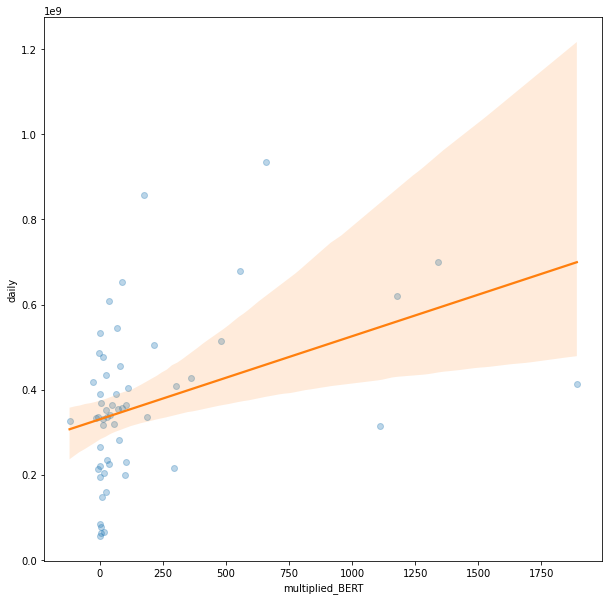

In [117]:
plt.figure(figsize = (10,10))
sns.regplot(data=merged_df.groupby('movie').sum(), x='multiplied_BERT', y='daily',
            line_kws = {'color': 'C1'},
            scatter_kws = {'color': 'C0', 'alpha': 0.3})
plt.show()

As the fitted regression is not super good when not encountering the time-series of the box office and sentiment, we choose to try a different approach (as in RQ1). We will analyze movies independently and instead investigate whether box office can be seen as being Granger causal from the multiplied sentiment scores. An example of the time series (box office and sentimennt) related to Avengers: Endgame is visualized below.

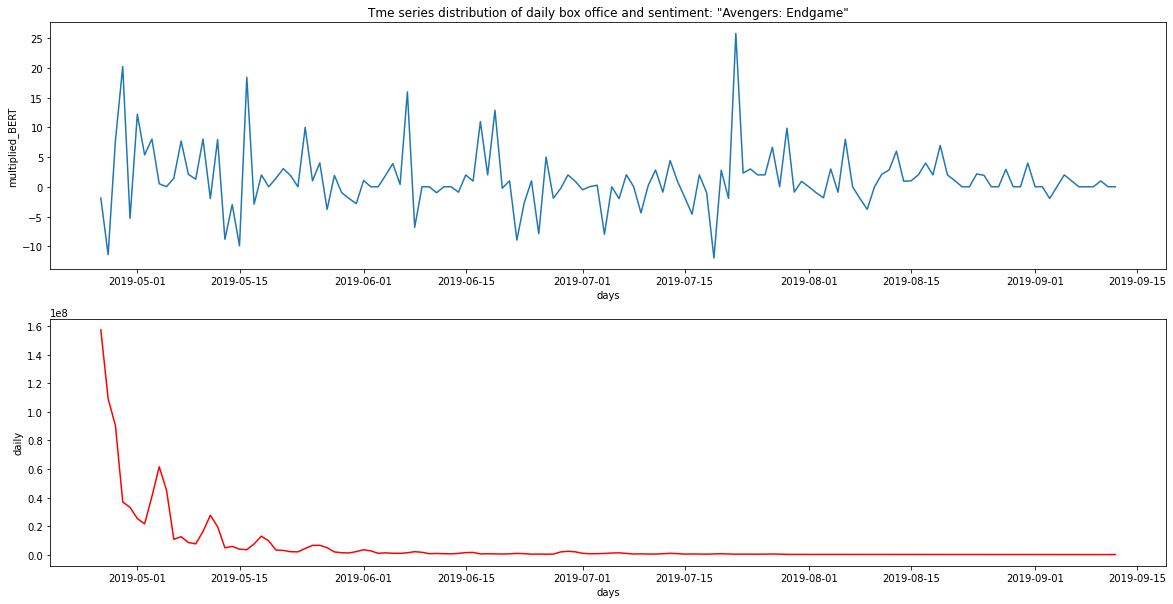

In [118]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,10))
ax[0].set(title='Tme series distribution of daily box office and sentiment: "Avengers: Endgame"')
sns.lineplot(x='days', y='multiplied_BERT', data=merged_df[merged_df.movie=='Avengers: Endgame'], ax=ax[0])
sns.lineplot(x='days', y='daily', data=merged_df[merged_df.movie=='Avengers: Endgame'], ax=ax[1], color='red')
plt.show()

And as the difference where we ensure zero mean.

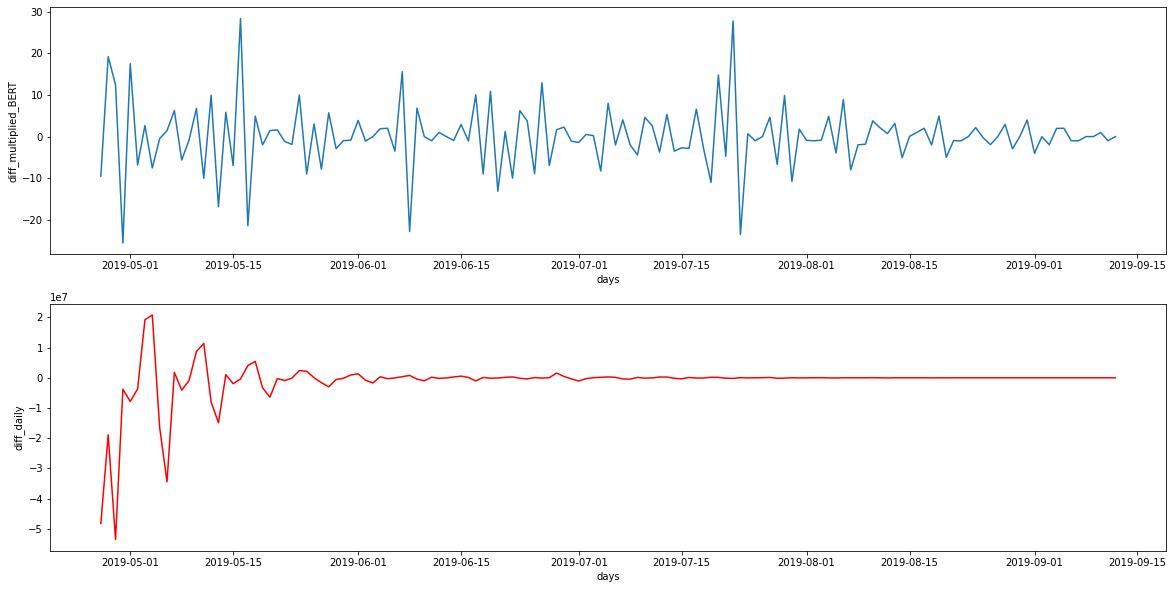

In [119]:
time_series = merged_df[merged_df.movie == 'Avengers: Endgame'].set_index('days')
time_series['diff_multiplied_BERT'] = time_series['multiplied_BERT'].diff()
time_series['diff_daily'] = time_series['daily'].diff()
time_series = time_series.dropna()

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,10))
sns.lineplot(x='days', y='diff_multiplied_BERT', data=time_series, ax=ax[0])
sns.lineplot(x='days', y='diff_daily', data=time_series, ax=ax[1], color='red')
plt.show()

We will apply the Granger causality test to all the movies to check whether there is a significant relation (that box office can be seen as being caused by sentiment, following granger terms) between box office sales and the sentiment score when analyzing time series on the individual movie level. We use the same code as in RQ2 but adjust the maximum lag to 3 as we are using the test on all movies, where some movies do not have as much time-points as others. In fact, some movies - like "Spider-Man: Homecoming" - has no sentiment attached to it for all days where it was airing in the cinemas, for which reason we try out the Granger approach and only compute it for movies that have a sufficient amount of quotes per box office day.

Similarly to RQ2 we will optimize the `maxlag` for the Granger causation on the time series of each movies where we use transform the time-series to having zero mean first.

In [120]:
def time_series_granger_pipeline_for_sentiment(titles):
    cause_box = {}
    for i, title in enumerate(titles):
        try:
            # determine movie
            time_series = merged_df[merged_df.movie == title].set_index('days')
            
            #transforming into stationary time series
            time_series['diff_multiplied_BERT'] = time_series['multiplied_BERT'].diff()
            time_series['diff_daily'] = time_series['daily'].diff()
            time_series = time_series.dropna()
            
            #choosing the best lag for Vector Autoregression by AIC score
            maxlag = best_lag_by_aic(time_series[['diff_daily', 'diff_multiplied_BERT']])
            
            gcm = grangers_causation(time_series[['diff_daily', 'diff_multiplied_BERT']], test='ssr_chi2test', maxlag=maxlag)
            cause_box[title] = (gcm, gcm < 0.05)
        except:
            print(f"Could not do Granger matrix for {title}")
            pass
       
    return cause_box

And now we use the defined functions to calculate the p-values from the Granger causality test.

In [121]:
titles = list(merged_df['movie'].unique())
cause_box = time_series_granger_pipeline_for_sentiment(titles)

Could not do Granger matrix for Bad Boys for Life
Could not do Granger matrix for Birds of Prey: And the Fantabulous Emancipation of One Harley Quinn
Could not do Granger matrix for Fast & Furious 7
Could not do Granger matrix for Spider-Man: Far from Home
Could not do Granger matrix for Spider-Man: Homecoming
Could not do Granger matrix for Onward
Could not do Granger matrix for Mission: Impossible - Fallout
Could not do Granger matrix for Sonic the Hedgehog
Could not do Granger matrix for Mission: Impossible - Rogue Nation
Could not do Granger matrix for Tenet
Could not do Granger matrix for The Invisible Man


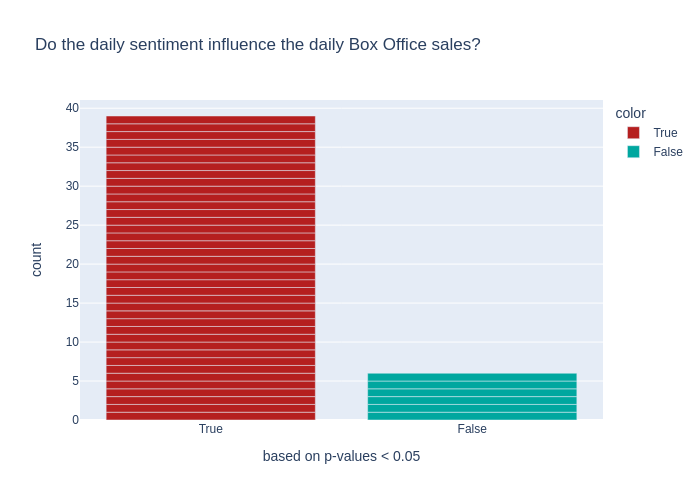

In [122]:
import plotly.express as px

sent2box = np.array([(movie, p_val, reject) for movie, (p_val, reject) in cause_box.items()])
temp = pd.DataFrame(sent2box).rename(columns={0: 'movie', 1: 'p_vals', 2: 'reject'})

fig = px.bar(x=temp.reject, y=(np.ones(len(temp.reject))), labels={'x':'based on p-values < 0.05', 'y':'count'},
            hover_name =temp.movie,
            color=temp.reject,
            color_discrete_sequence=['#B51F1F', '#00A79F'],
            title='Do the daily sentiment influence the daily Box Office sales?')
fig.update_layout(width=700, height=500)
fig.show('png')

So there does not seem to be a complete agreeing whether the time series sentiment of a movie influence the time series box office of the same movie or not, but we see that it seems like there's a larger fraction of movies where the Box Office temporal data can be said to be Granger caused by the daily multiplied sentiment of the movie.

But wait a minute! This is a multiple comparisons problem as we are investigating several statistical tests at once. Let's first adjust the p-values with the Bonferroni method to account for false-positives before making further conclusions.

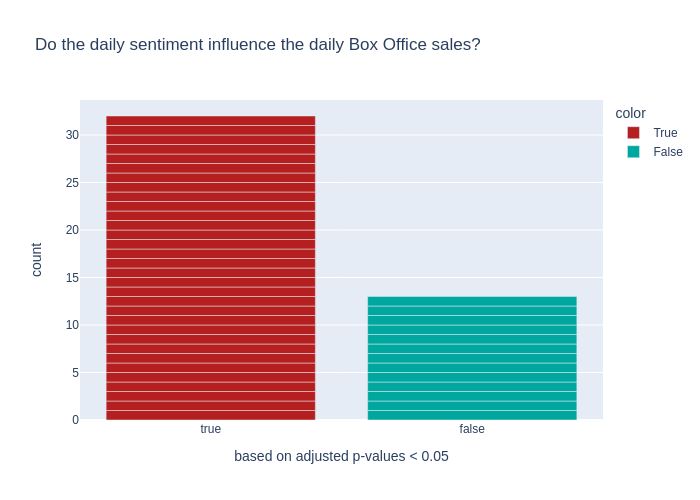

In [123]:
reject_sent2box, adj_pvals_sent2box, _, _ = multipletests(sent2box[:,1].astype(float), alpha=0.05, method='bonferroni')
adj_pvals_df = pd.DataFrame(adj_pvals_sent2box, reject_sent2box)
adj_pvals_df['movie'] = sent2box[:,0]
adj_pvals_df = adj_pvals_df.reset_index().rename(columns={0: 'p_vals', 'index': 'reject'})

fig = px.bar(x=adj_pvals_df.reject, y=(np.ones(len(adj_pvals_df.reject))), labels={'x':'based on adjusted p-values < 0.05', 'y':'count'},
            hover_name =adj_pvals_df.movie,
            color=adj_pvals_df.reject, #sent2box[:,0],
            color_discrete_sequence=['#B51F1F', '#00A79F'],
            title='Do the daily sentiment influence the daily Box Office sales?')
fig.update_layout(width=700, height=500)
fig.show('png')

Indeed we do observe the same tendency when looking at the statistical results based on the adjusted p-values. These are more valid and hence we conclude that the multiplied sentiment scores can be regarded as causing (in the sense of Granger causality) the Box Office sales for most of the considered movies, but not for all. This might be why the linear regression was not a suficient fit on the summed data for movies.

**Conclusion:** Even though the linear regression between multiplied BERT sentiment and Box Office sales are linearly related when examining the attributes without the temporal, we believe that the fit is too bad for the total sentiment scores for movies to be a good predictor on the total Box Office sales for movies. Through further investigations, we see that the daily box office sales for most movies can be said to be caused (Granger causality) by the daily multiplied BERT sentiment of quotes but that there is a non-trivial amount of movies for which this relation between daily multiplied sentiment and daily box office revenue is not statistical significant.

This suggest that the sentiment/mood of quotes occuring in the period where a movie is on-screen in cinemas for most movies influence how much the movie will earn. Under the assumption that movie tickets are approximately equally expensive, this suggest that more tickets are sold for movies that have a positively related media coverage.

---

### Weighted daily average sentiment 

We would like to check if the conclusion is different if we re-engineer the way daily sentiment is calculated. Instead of summing - which we still believe is the most valid approach when related to box office data - we keep the daily sentiment of a quote within the range [-1, 1] by calculating the weighted average. This approach will also be used for the IMDb research (sub)-question.

## 3.2: Sentiment and IMDb - (WIP)  <a class="anchor" id="chapter32"></a>

### Narrowing in the data frame to the use-case

We start by cutting down the dataframe to its essence that is related to this research (sub)question. Other than the descriptive information about the movies, we need ratings from users, critics and eventually the distribution of votes across specific ratings. We might want to analyse the description of the movie too. Here are the attributes we keep so far (we might extend the selection later):

`original_title` is the movie title agreeing with the Quotebank data.''

`genre` is the movie genre.

`year` is the year.

`date_published` is the release date of the movie.

`description` is a description about the movie. 

`metascore` is a rating of the film based on the world's most respective critics (weighted average). Possible maximum is 100. 

`weighted_average_vote` is the score IMDb weighted average rating. This is what appears on the IMDb webpage and is based on users votes. Possible maximum is 10.

`votes` is the total number of votes.

`votes_[1-10]` is number of votes with the specific rating.


In [124]:
movies = pd.read_csv(rf"{data_dir}{os.sep}IMDb{os.sep}IMDb movies.csv", low_memory=False)
df_imdb = movies.merge(ratings, on='imdb_title_id')

In [125]:
overlap = np.intersect1d(df_imdb.original_title.unique(), df_Quotebank.movie.unique())
print(overlap)
print(f"\nsize of overlap of movie titles: {overlap.__len__()}")

['Aladdin' 'Aquaman' 'Avengers: Age of Ultron' 'Avengers: Endgame'
 'Avengers: Infinity War' 'Bad Boys for Life'
 'Batman v Superman: Dawn of Justice' 'Beauty and the Beast'
 'Birds of Prey: And the Fantabulous Emancipation of One Harley Quinn'
 'Black Panther' 'Bohemian Rhapsody' 'Captain America: Civil War'
 'Captain Marvel' 'Deadpool' 'Deadpool 2' 'Despicable Me 3' 'Dolittle'
 'Fantastic Beasts and Where to Find Them'
 'Fantastic Beasts: The Crimes of Grindelwald' 'Fast & Furious 7'
 'Finding Dory' 'Frozen II' 'Guardians of the Galaxy Vol. 2'
 'Incredibles 2' 'Inside Out' 'Joker' 'Jumanji: The Next Level'
 'Jumanji: Welcome to the Jungle' 'Jurassic World'
 'Jurassic World: Fallen Kingdom' 'Minions'
 'Mission: Impossible - Fallout' 'Mission: Impossible - Rogue Nation'
 'Onward' 'Rogue One' 'Sonic the Hedgehog' 'Spectre'
 'Spider-Man: Far from Home' 'Spider-Man: Homecoming'
 'Star Wars: Episode IX - The Rise of Skywalker'
 'Star Wars: Episode VII - The Force Awakens'
 'Star Wars: Epis

We only make use of the movies that we restricted ourselves to in the Quotebank data. This is done below.

In [126]:
# choose movies
df_imdb = df_imdb[np.isin(df_imdb.original_title, overlap)]

# choose years
Quotebank_years = pd.Series([date.split("-")[0] for date in df_Quotebank.days.unique()]).unique()
df_imdb = df_imdb[np.isin(df_imdb.year, Quotebank_years)]

# update indeces
df_imdb.index = np.arange(len(df_imdb))

In [127]:
print(f"Shape of dataframe: {df_imdb.shape}")
df_imdb.head()

Shape of dataframe: (58, 70)


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0369610,Jurassic World,Jurassic World,2015,2015-06-11,"Action, Adventure, Sci-Fi",124,USA,English,Colin Trevorrow,...,7.2,32243.0,7.3,6381.0,6.8,762.0,7.1,72876.0,6.8,217418.0
1,tt0451279,Wonder Woman,Wonder Woman,2017,2017-06-01,"Action, Adventure, Fantasy",141,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,7.6,29053.0,7.8,7220.0,7.0,723.0,7.7,67709.0,7.2,190337.0
2,tt1051906,L'uomo invisibile,The Invisible Man,2020,2020-03-27,"Horror, Mystery, Sci-Fi",124,"Canada, Australia, USA",English,Leigh Whannell,...,7.1,6778.0,7.2,1603.0,6.9,373.0,7.2,15568.0,7.0,49787.0
3,tt1270797,Venom,Venom,2018,2018-10-04,"Action, Adventure, Sci-Fi",112,"China, USA","English, Mandarin, Malay",Ruben Fleischer,...,7.0,14589.0,7.2,3063.0,6.3,556.0,6.6,35509.0,6.6,125428.0
4,tt1386697,Suicide Squad,Suicide Squad,2016,2016-08-13,"Action, Adventure, Fantasy",123,USA,"English, Japanese, Spanish",David Ayer,...,6.2,27359.0,6.4,4816.0,5.7,740.0,5.9,60869.0,5.9,203451.0


We are only supposed to have 56 movies in the frame. Let's find out which ones are duplicated.

In [128]:
movies, freq = np.unique(df_imdb.original_title, return_counts=True)
movies[freq > 1]

array(['Joker', 'The Invisible Man'], dtype=object)

Let's investigate these and see which duplicate is the false one. Then we outfilter these ones.

In [129]:
df_imdb[df_imdb.original_title == 'Joker']

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
47,tt5611648,Joker,Joker,2016,2016-08-12,"Comedy, Drama",130,India,Tamil,"Raju Murugan, Raju Saravanan",...,8.1,22.0,8.0,2.0,6.6,19.0,8.1,171.0,8.2,870.0
54,tt7286456,Joker,Joker,2019,2019-10-03,"Crime, Drama, Thriller",122,"USA, Canada",English,Todd Phillips,...,8.4,35220.0,8.3,7620.0,7.9,630.0,8.2,77947.0,8.4,281183.0


In [130]:
df_imdb[df_imdb.original_title == 'The Invisible Man']

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
2,tt1051906,L'uomo invisibile,The Invisible Man,2020,2020-03-27,"Horror, Mystery, Sci-Fi",124,"Canada, Australia, USA",English,Leigh Whannell,...,7.1,6778.0,7.2,1603.0,6.9,373.0,7.2,15568.0,7.0,49787.0
55,tt7651078,The Invisible Man,The Invisible Man,2017,2018-02-04,Sci-Fi,88,USA,English,"Khian Bartlett, Carol Damgen",...,4.7,6.0,4.0,7.0,4.0,10.0,3.5,57.0,3.2,35.0


The rows to be removed are 47 and 55 - this can also be seen by the number of votes on the IMDb ratings.

In [131]:
df_imdb = df_imdb.drop([47, 55])
df_imdb.index = np.arange(len(df_imdb))
print(f"Shape of dataframe: {df_imdb.shape}")

Shape of dataframe: (56, 70)


In [132]:
votes_n = [f"votes_{n}" for n in range(1,11)]
print(votes_n)

['votes_1', 'votes_2', 'votes_3', 'votes_4', 'votes_5', 'votes_6', 'votes_7', 'votes_8', 'votes_9', 'votes_10']


In [133]:
# attributes of interest
aoi = np.union1d(votes_n, ['original_title', 'genre', 'year', 'date_published', 'description', 'metascore', 'weighted_average_vote']).tolist()

print("Attributes to keep:")
aoi

Attributes to keep:


['date_published',
 'description',
 'genre',
 'metascore',
 'original_title',
 'votes_1',
 'votes_10',
 'votes_2',
 'votes_3',
 'votes_4',
 'votes_5',
 'votes_6',
 'votes_7',
 'votes_8',
 'votes_9',
 'weighted_average_vote',
 'year']

In [134]:
df_imdb = df_imdb[aoi]
df_imdb.head()

,date_published,description,genre,metascore,original_title,votes_1,votes_10,votes_2,votes_3,votes_4,votes_5,votes_6,votes_7,votes_8,votes_9,weighted_average_vote,year
0,2015-06-11,"A new theme park, built on the original site o...","Action, Adventure, Sci-Fi",59.0,Jurassic World,6535,51492,5015,8511,17147,40501,94206,168772,126084,51249,7.0,2015
1,2017-06-01,When a pilot crashes and tells of conflict in ...,"Action, Adventure, Fantasy",76.0,Wonder Woman,10173,77571,4129,6184,11009,24811,58393,123602,140814,79217,7.4,2017
2,2020-03-27,When Cecilia's abusive ex takes his own life a...,"Horror, Mystery, Sci-Fi",72.0,The Invisible Man,2101,7863,1074,1732,3040,7405,19223,41258,34089,12020,7.1,2020
3,2018-10-04,A failed reporter is bonded to an alien entity...,"Action, Adventure, Sci-Fi",35.0,Venom,4681,36096,3719,7151,13249,29043,63473,97505,63947,24744,6.7,2018
4,2016-08-13,A secret government agency recruits some of th...,"Action, Adventure, Fantasy",40.0,Suicide Squad,23814,52301,18294,28084,45219,78385,120917,120338,69754,29368,6.0,2016


### Weighted average sentiment
We then want to calculate a representative sentiment score associated with each movie, that can eventually be scaled and compared with the IMDb ratings by users and critics. We already saw the approach in the box office investigation but we will motivate it more here.

We still want to account for the importance of the number of occurrences of a quote related to a movie, but since we aim at comparing the sentiment scores for movies to the IMDb rating we cannot multiply and sum the sentiments on a given day, as sentiment scores can possibly be infinite positive or negative with that approach. Instead we calculate a daily sentiment score for each movie as the weighted average of the sentiment scores for all quotes related to the given movie on that day, where the number of occurrences is used as the weighting term. This is done by iterating through the `groupby` object that is created when grouping Quotebank by movie and dates.

In [135]:
temp_BERT = {}
temp_VADER = {}

for (movie, date), subframe in tqdm(df_Quotebank.groupby(['movie', 'days'])):    
    weighted_average_BERT = (subframe.numOccurrences * subframe.positive_BERT_score).sum() / subframe.numOccurrences.sum() 
    weighted_average_VADER = (subframe.numOccurrences * subframe.VADER_score).sum() / subframe.numOccurrences.sum()
    
    temp_BERT[(movie, date)] = weighted_average_BERT
    temp_VADER[(movie, date)] = weighted_average_VADER

  0%|          | 0/12717 [00:00<?, ?it/s]

In [136]:
wAvg_per_day = pd.DataFrame([pd.Series(temp_BERT), pd.Series(temp_VADER)]).T
wAvg_per_day = wAvg_per_day.rename(columns={0: 'weighted_BERT', 1: 'weighted_VADER'})
wAvg_per_day.index.names = ['movie', 'days']
wAvg_per_day

weighted_BERT  weighted_VADER
movie    days                                     
Aladdin  2019-01-02       0.998775        0.992900
         2019-01-03       0.676791        0.136600
         2019-01-08       0.056652        0.182133
         2019-01-13       0.999398        0.872000
         2019-01-15       0.997019        0.486250
...                            ...             ...
Zootopia 2017-11-13      -0.965401        0.000000
         2017-12-07      -0.034033        0.000000
         2017-12-20       0.997421        0.680800
         2017-12-26       0.727826        0.440400
         2017-12-27      -0.997922        0.688000

[12717 rows x 2 columns]

And by using the `describe` method of pandas we clearly see that the max- and minimum range is definetely bounded in the interval [-1, 1] that the re-expressed positive BERT scores also are.

In [137]:
wAvg_per_day.describe()

,weighted_BERT,weighted_VADER
count,12717.000000,12717.000000
mean,0.289380,0.217691
std,0.685905,0.442115
min,-0.999642,-0.998300
25%,-0.196137,-0.057550
50%,0.459575,0.237360
75%,0.975217,0.565662
max,0.999784,0.998500


When investigating the sentiment of quotes' relation to the box office sales we were restricted to the time period in which the movie was airing in the movie theaters. This is however not the case for IMDb as the data set does not contain the IMDb scores as a time series but solely as single values. We therefore find it relevant to use all of the quotes as the IMDb score is based on running votes/ratings and can have been affected by sentiment of quotes at all time points.

For this reason we simply average the daily sentiment scores for each movie to obtain the final sentiment score associated with the movies. We provide a snippet below.

In [138]:
sents_movie = wAvg_per_day.groupby('movie').mean()
sents_movie.head()

,weighted_BERT,weighted_VADER
movie,,
Aladdin,0.407270,0.379497
Aquaman,0.297491,0.347461
Avengers: Age of Ultron,0.191910,0.215147
Avengers: Endgame,0.171537,0.289586
Avengers: Infinity War,0.173169,0.143259


As we are interested in changing the scaling of this score to a predefined scaling, we make use of normalization. It resembles the min-max normalization we encountered in the lectures but differ by using our knowledge of the range of the scale that the data is on rather than using the minimum and maximum observed sentiment scores. Thus the formula for rescaling data in the range $[s_{low}, s_{high}]$ to the range $[t_{low}, t_{high}]$ looks as follows to ca:

$$
(t_{high}-t_{low}) \frac{x - s_{low}}{s_{high}-s_{low}} + t_{low}
$$

The sentiment range theoretically lies between [-1, 1] and IMDb scores can theoretically lie between [1, 10] if all quotes or votes, respectively, about a movie are at the extreme values. Thus, the sentiment scores become:

In [139]:
sents_movie = np.round((10-1) * (sents_movie + 1) / 2 + 1, 2)
sents_movie.head()

,weighted_BERT,weighted_VADER
movie,,
Aladdin,7.33,7.21
Aquaman,6.84,7.06
Avengers: Age of Ultron,6.36,6.47
Avengers: Endgame,6.27,6.80
Avengers: Infinity War,6.28,6.14


In [140]:
sents_movie.describe()

,weighted_BERT,weighted_VADER
count,56.000000,56.000000
mean,6.874821,6.650000
std,0.898643,1.026142
min,4.620000,4.150000
25%,6.277500,6.405000
50%,6.900000,6.860000
75%,7.507500,7.210000
max,8.980000,8.780000


And the sentiment scores are in fact now within that range :-) 
Let's see if the distribution of sentiment scores resemble the `weighted_average_score` that is based on IMDb users or the `metascore` that are based on critics opinion. We need to rescale `metascore` that has the possible range [0, 100].

Let's investigate these and see which duplicate is the false one. Then we outfilter these ones.

In [141]:
metascore = (10-1) * df_imdb.metascore / 100 + 1
df_imdb.loc[:, 'metascore'] = metascore
metascore.head()


0    6.31
1    7.84
2    7.48
3    4.15
4    4.60
Name: metascore, dtype: float64

We will also create a score representing the average of the users and critics ratings from IMDb. Let's add everything to the imdb dataframe and describe it!

In [142]:
merged_df = df_imdb.merge(sents_movie, how='left', left_on=['original_title'], right_on=['movie']).set_index('original_title')
merged_df['average_imdb'] = 1/2 * (merged_df.weighted_average_vote + merged_df.metascore)
merged_df = merged_df[['weighted_average_vote', 'metascore', 'weighted_BERT', 'average_imdb']]
merged_df.describe()

,weighted_average_vote,metascore,weighted_BERT,average_imdb
count,56.000000,56.000000,56.000000,56.000000
mean,7.192857,6.806607,6.874821,6.999732
std,0.660539,1.214529,0.898643,0.865211
min,5.600000,3.340000,4.620000,4.470000
25%,6.700000,6.040000,6.277500,6.425000
50%,7.200000,6.850000,6.900000,7.092500
75%,7.725000,7.750000,7.507500,7.631250
max,8.500000,9.460000,8.980000,8.780000


So, by looking at the descriptive statistics of the scores neither the weighted BERT nor VADER seem to be that far from modelling the IMDb trends. This is further seen in the plots below.

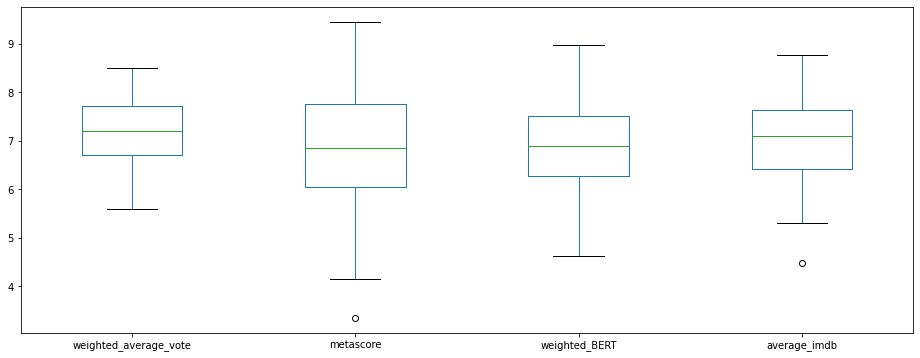

In [143]:
merged_df.boxplot(figsize=((16,6)), grid=False)
plt.show()

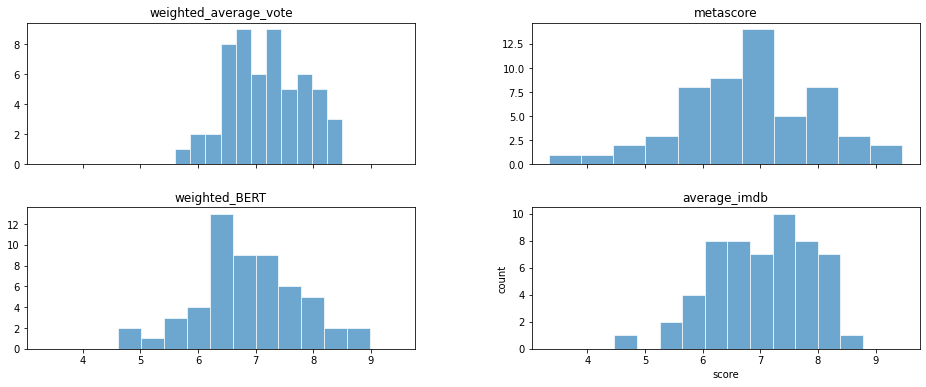

In [144]:
merged_df.hist(bins=11, figsize=((16,6)), grid=False, edgecolor='white', linewidth=1, alpha=0.65, sharex=True)[0]
plt.xlabel('score')
plt.ylabel('count')
plt.show()

But what about more advanced statistics than just examining the distributions and instead looking at how these scores relate together using a statistical test. We will try to use the Kolmogorov-Schmirnov test to check if our ratings found from the sentiment score can be seen as originating from the same distribution as either the `weighted_average_vote`, the `metascore` or the `average_imdb` from IMDb.

In [145]:
kstest(merged_df.weighted_BERT, merged_df.weighted_average_vote)

KstestResult(statistic=0.23214285714285715, pvalue=0.0977863409490219)

In [146]:
kstest(merged_df.weighted_BERT, merged_df.metascore)

KstestResult(statistic=0.125, pvalue=0.7789498597918985)

In [147]:
kstest(merged_df.weighted_BERT, merged_df.average_imdb)

KstestResult(statistic=0.16071428571428573, pvalue=0.4681496145911523)

**Conclusion:** So the ratings created from the weighted average daily sentiment for movies can not be said to be drawn from the same distribution as either of the IMDb based ratings. This is determined with a significance level of 5% and in this case the adjusted p-values would just amplify this tendency. In other words there is no significant relation between the sentiment of a movie across all time 

---

# RQ 4: Interpret if there is a bias in the data <a class="anchor" id="chapter4"></a>

- Is there a bias within the quotes and sentiment or rating of a movie w.r.t gender, ethnicity, etc.?

## 4.1. Are quotes in quotebank regarding movies biased? <a class="anchor" id="chapter41"></a>

We first aim to analyze how different genders are represented in the quotes regarding the movies. For this, we chose the highly represented top-quoted movies (about 10 per year), to get a meaningful number of quotes per movie, and also to analyze movies that are so popular that they potentially reach big parts of society (blockbusters), in order to analyze who makes quotes about his opinion about movies in general, and not just niche movies with a very limited interest group. 

Our first approach to getting the gender of a speaker was a specialized python library that was able to estimate the gender of a speaker based on the first name, called `gender-guesser`. While it worked quite well for a majority of names, we found 2 shortcomings: First, it wasn't able to deal with all speakers we had available, as e.g. J.J. of J.J. Abrams couldn't be matched. Also, it supported an only binary approach to gender, which we also wanted to extend to also include non-binary genders. 

Hence, we instead decided to extract the gender from the given wikidata. For this, we first read the data in, and then check for the given qids for gender. We then use the library `wikidata` to get meaningful names for the gender qids. 

In [ ]:
df_wikidata = pd.read_parquet('exploratory/data/speaker_attributes.parquet')
df_wikidata = df_wikidata.set_index('id')

In [ ]:
df_wikidata = df_wikidata.dropna(subset=['gender'])
df_wikidata['gender'] = df_wikidata['gender'].apply(lambda x: x[0])
df_wikidata['gender'].unique()

In [ ]:
client = Client()
qid_to_gender = dict()
for qid in df_wikidata['gender'].unique():
    if qid is not None:
        entity = client.get(qid, load=True)
        try:
            qid_to_gender[qid] = entity.data['labels']['en']['value']
        except:
            pass
qid_to_gender

In the following, we decided to keep male and female, and summarize other genders with a 'diverse' label. We so apply this to our dataframe of wikipedia properties.

In [ ]:
df_wikidata['gender'] = df_wikidata['gender'].apply(lambda x: 'male' if x == 'Q6581097' else 'female' if x == 'Q6581072' else 'diverse')

In [ ]:
def list_to_qid(x):
    try:
        return x[0]
    except:
        return None
df_wikidata['ethnic_group'] = df_wikidata['ethnic_group'].apply(list_to_qid)

In [ ]:
df_wikidata['ethnic_group'].unique()

In [ ]:
from wikidata.client import Client
client = Client()
for qid in df_wikidata['ethnic_group'].unique():
    if qid is not None:
        entity = client.get(qid, load=True)
        try:
            print(entity.data['labels']['en']['value'])
        except KeyError:
            pass

To further investigate, we create a dataframe to map our shared_IDs with their gender. We give these shared_IDs to a set of qids referring to the same person (e.g. Donald Trump, President Trump, etc.). To get the gender, we decided to check all qids and stop after the first match (assuming that each article gives the same gender to a person, if any). 

In [ ]:
map_gender = df_quotes[['shared_ID', 'qids']].drop_duplicates(subset=['shared_ID'])
map_gender.head()

In [ ]:
map_gender.shape

In [ ]:
def get_gender(row):
    for qid in row['qids']:
        try:
            gender = df_wikidata.loc[qid, 'gender']
            row['gender'] = gender
            return row
        except KeyError:
            continue
    row['gender'] = None
    return row
map_gender = map_gender.apply(get_gender, axis=1)

In [ ]:
map_gender['gender'].value_counts()

In [ ]:
map_gender = map_gender.set_index('shared_ID')

In [ ]:
df_quotes = df_quotes.merge(map_gender, how='left', left_on='shared_ID', right_index=True)
df_quotes.head()

In [ ]:
df_quotes['gender'].value_counts()

In [ ]:
df_quotes['gender'].value_counts().plot.pie()

In [ ]:
df_quotes.drop_duplicates('shared_ID')['gender'].value_counts()

In [ ]:
df_quotes.drop_duplicates('shared_ID')['gender'].value_counts().plot.pie()

First interesting finding: A HUGE majority of quotes come from speakers who identify as male, nearly 5 times as much as from women. Other genders are a very small minority. This is pretty outstanding, as one would rather expect male and female to be at about 50 % each. As about 1.2 million of a total of 300 million Americans identify as non-binary (https://williamsinstitute.law.ucla.edu/publications/nonbinary-lgbtq-adults-us/), we would assume the same about 0.4 % of non-binary people, while here we get only 0.1 % of quotes from people identifying as non-binary. We would conclude that mostly women might be underrepresented. 
The same holds for the number of unique speakers. Only 35 are diverse, and there are about 4 times as much women as men.

Another interesting point to check is whether women or men (as the number of diverse quotes and speakers were so low, we continue our investigation on male and female only) tend to be more positive or negative. For this, we first look at the distribution of BERT_scores (the ones used earlier for sentiment analysis), and then check whether these distributions differ. 

In [ ]:
axs = sns.displot(df_quotes, x="positive_BERT_score", col="gender")

In [ ]:
df_quotes[df_quotes['gender'] == 'male']['positive_BERT_score'].mean()
df_quotes[df_quotes['gender'] == 'female']['positive_BERT_score'].mean()
df_quotes[df_quotes['gender'] == 'male']['positive_BERT_score'].median()
df_quotes[df_quotes['gender'] == 'female']['positive_BERT_score'].median()

In [ ]:
male_scores = df_quotes[df_quotes['gender'] == 'male']['positive_BERT_score']
female_scores = df_quotes[df_quotes['gender'] == 'female']['positive_BERT_score']
kstest(male_scores, female_scores, alternative='two-sided')

We decided for the Kolmogorov-Smirnoff two-sided test to compare the distributions of male and female sentiments. Given our p-value, we can reject the null hypothesis that both distributions are the same. From the higher mean and median of female sentiments, we would deduce that women tend to talk slightly more positive about movies than men do. 

In [ ]:
male_movies = df_quotes[df_quotes['gender'] == 'male'].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})
male_medians = male_movies['median_sentiment']
male_movies.head(5)

In [ ]:
female_movies = df_quotes[df_quotes['gender'] == 'female'].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})
female_medians = female_movies['median_sentiment']
female_movies.head(5)

In [ ]:
male_movies.sort_values('no_of_quotes', ascending=False).head()

In [ ]:
female_movies.sort_values('no_of_quotes', ascending=False).head()

Also, we can see that the movies that more than half of all quotes were positively speaking about deviate quite between men and women, with Fast & Furious 7 and Incredibles 2 being the only movies that appear in both top-5 collections. We are now interested in movies where men and women actually disagree, where majorities are positive for one and negative for the other group. 

In [ ]:
diffs = (male_medians - female_medians).dropna().sort_values(ascending=False)
diffs.head(5)

In [ ]:
diffs.tail(5)

In this case, a very high (positive) difference of more than 0.5 means that more than 50 % of male quotes were positive, and more than 50 % of female quotes were negative, which apparently is the case for Deadpool. Accordingly, high negative differences that more than 50 % of female quotes were negative, and more than 50 % of female quotes were positive, which is the case for Despicable Me 3 and Zootopia. 

Let's investigate those two extreme movies (Deadpool and Despicable Me 3) a bit further to see what happens there.

In [ ]:
df_quotes[(df_quotes['gender'] == 'male') & (df_quotes['movie'].isin(['Deadpool', 'Despicable Me 3']))].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})

In [ ]:
df_quotes[(df_quotes['gender'] == 'female') & (df_quotes['movie'].isin(['Deadpool', 'Despicable Me 3']))].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})

In [ ]:
df_quotes[(df_quotes['gender'] == 'male') & (df_quotes['movie'] == 'Deadpool')]['positive_BERT_score'].plot.hist()

In [ ]:
df_quotes[(df_quotes['gender'] == 'female') & (df_quotes['movie'] == 'Deadpool')]['positive_BERT_score'].plot.hist()

In [ ]:
df_quotes[(df_quotes['gender'] == 'male') & (df_quotes['movie'] == 'Despicable Me 3')]['positive_BERT_score'].plot.hist()

In [ ]:
df_quotes[(df_quotes['gender'] == 'female') & (df_quotes['movie'] == 'Despicable Me 3')]['positive_BERT_score'].plot.hist()

In [ ]:
df_quotes[df_quotes['movie'].isin(['Deadpool', 'Despicable Me 3'])].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})

We deduce the following: It is actually the case that in both movies, a majority of male/female voters, respectively, are positive, while the opposite group is primarily negative towards the movie. Interestingly, when taking the overall median, would rather follow the male sentiment. This is of course due to the relative high number of male voters when compared to the number of female voters.

---

## 4.2. Bias in Internet Movie Database ratings <a class="anchor" id="chapter42"></a>

We also check the (un)biasedness of our second potentially biased dataset: The ratings from IMDb. Here, we check for a bias both in terms of gender and in terms of age groups. Let's see, how much influence majority groups in both properties might have on the total perception of a movie.

For our analysis, we were a bit limited by our dataset. The main problem is, that we only get a mean vote and the number of votes per group (e.g. male/female, age < 18, 18 to 30, ...). We are clearly missing a standard diviation here to make statistically valid statements about these topics in general. However, it is still possible for us to reason on a movie-by-movie basis.

We were trying to find other datasets, however, very few datasets (except for Quotebank and the imdb set) give information about the gender, ethnicity, age, etc. of a person. Our strongest candidate was the movielens dataset, but which only covers this information in a dataset with ratings from before 2003. 

In [6]:
def standardize_col(col):
    try:
        return (col - col.mean())/col.std()
    except:
        return col

In [7]:
movies = clean_imdb(movies)
imdb = movies.merge(ratings, on='imdb_title_id')
relevant_years = imdb[imdb['year'].isin([2015, 2016, 2017, 2018, 2019, 2020])]
relevant_years_stdz = relevant_years.apply(standardize_col, axis=0)

First, we check the distribution among mean percentages of male voters per movie. 

0.5802392635264316

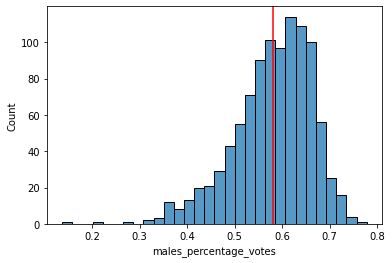

In [8]:
relevant_years['males_percentage_votes'] = relevant_years['males_allages_votes'] / relevant_years['votes']
#relevant_years['males_percentage_votes'].plot.hist(bins=50)
sns.histplot(data=relevant_years, x='males_percentage_votes')
plt.axvline(x=relevant_years['males_percentage_votes'].mean(),
            color='red')
relevant_years['males_percentage_votes'].mean()

We observe a slightly left-skewed distribution, with a mean of .58, while we would expect a mean of 0.5. 
We can therefore test whether the mean of 0.58 is significantly different from 0.5, which we consider the distribution of male and females in the world (our population). For this, the two-sided 1-sample ttest is a perfect match.

In [9]:
ttest_1samp(relevant_years['males_percentage_votes'], 0.5)

Ttest_1sampResult(statistic=30.859035907939063, pvalue=4.013537684447491e-147)

The p value let's us reject the Null Hypothesis that females and males are equally (50 % each) in the number of ratings. Hence, the averages tend to cover more male reviewers than female reviewers. We would derive from this result that average scores might be biased towards male opinions. 

Let's have a look at the left and right extremes, just to see what kinds of movies that might be. It looks like there are 3 movies with very low male percentage and 1-5 with a very high. So, we just have a look at the 5 highest and lowest percentage of male votes.

In [10]:
relevant_years[['original_title','males_percentage_votes']].sort_values('males_percentage_votes').head(5)

,original_title,males_percentage_votes
566,Meet the Blacks,0.137320
552,After,0.215840
706,"Everything, Everything",0.278886
548,Forever My Girl,0.327401
855,The Sun Is Also a Star,0.328246


In [11]:
relevant_years[['original_title','males_percentage_votes']].sort_values('males_percentage_votes', ascending=False).head(5)

,original_title,males_percentage_votes
500,Mai sing,0.777633
279,The Gunman,0.748229
466,Turbo Kid,0.746878
730,Kickboxer: Retaliation,0.739533
502,Cop Car,0.736558


## How successful are movies liked by men/women?

As a first step, we analyze the influence of the average vote by men and women on the total mean. For this, we fit an OLS model to predict the total mean and have a look at the coefficients. 

In [12]:
mod = smf.ols(formula='mean_vote ~ females_allages_avg_vote + males_allages_avg_vote', data=relevant_years_stdz)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              mean_vote   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     8391.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:00:50   Log-Likelihood:                 25.248
No. Observations:                 993   AIC:                            -44.50
Df Residuals:                     990   BIC:                            -29.79
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In this case, we see a strong influence of both averages. We would deduce that both averages have significant influence on the total mean of votes for a movie. 

In [20]:
our_movies = imdb[imdb['original_title'].isin(df_Quotebank['movie'].unique())]

In [21]:
pearsonr(our_movies['females_allages_avg_vote'], our_movies['mean_vote'])

(0.9379943444821572, 1.3897526291875807e-25)

In [24]:
pearsonr(our_movies['males_allages_avg_vote'], our_movies['mean_vote'])

(0.9812127979657046, 7.76964106439126e-39)

From this plot, we see no direct correlation between the mean vote of a movie and its success in terms of income (a shame...). We would therefore argue that the income of a movie is also independent of the average vote by male and female reviewers. For completeness, we also add the two plots with male and female average votes, underlying our hypothesis:

[None]

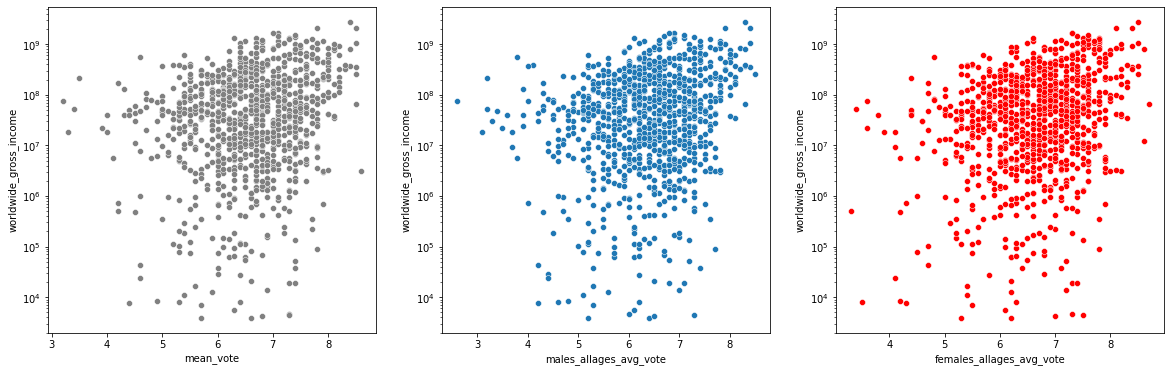

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
sns.scatterplot(x='mean_vote', y='worldwide_gross_income', data=relevant_years, ax=ax[0], color='grey')
ax[0].set(yscale='log')
sns.scatterplot(x='males_allages_avg_vote', y='worldwide_gross_income', data=relevant_years, ax=ax[1])
ax[1].set(yscale='log')
sns.scatterplot(x='females_allages_avg_vote', y='worldwide_gross_income', data=relevant_years, ax=ax[2], color='red')
ax[2].set(yscale='log')

## Average vote by men?

Let's see if the trend from the quotebank data is agreed on here: That men are on average giving lower scores than women. The distribution of average votes on movies by men or women might indicate so. 

Let us be very clear with the hypothesis to check here: We want to check whether the mean rating score on a movie is significantlly different between female and male voters. 

male avg vote: 5.8171721760197554,     female avg vote 6.039408212278779


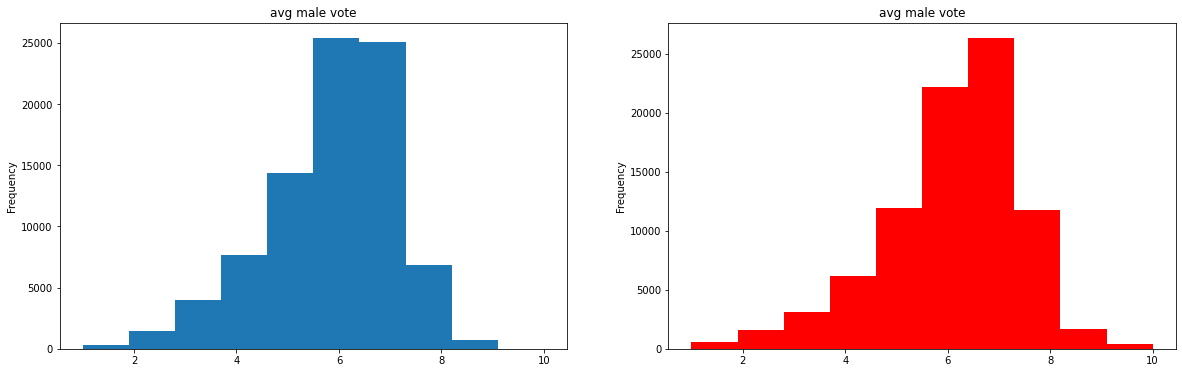

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ratings['males_allages_avg_vote'].plot.hist(ax=ax[0])
ax[0].set(title='avg male vote')
ratings['females_allages_avg_vote'].plot.hist(ax=ax[1], color='red')
ax[1].set(title='avg male vote')

male_mean = ratings['males_allages_avg_vote'].mean()
female_mean = ratings['females_allages_avg_vote'].mean()
print(f'male avg vote: {male_mean},     female avg vote {female_mean}')

male avg vote: 6.355991943605237,     female avg vote 6.5987915407854985


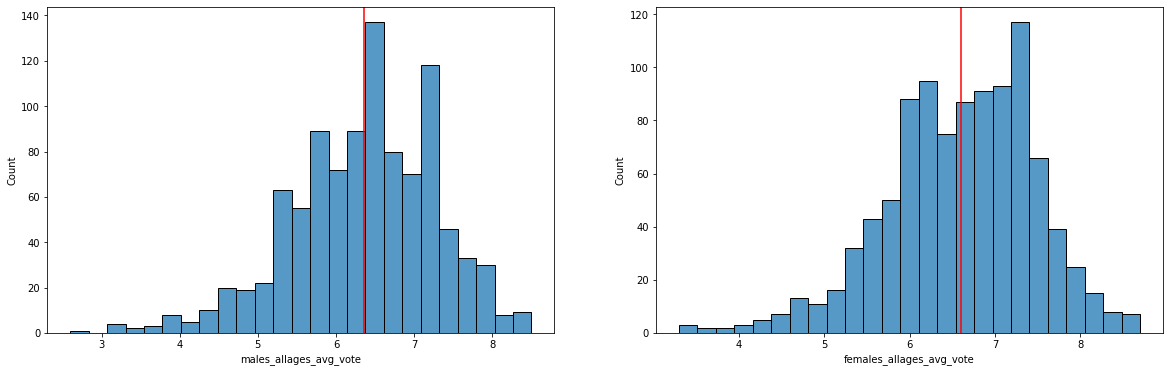

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
sns.histplot(data=relevant_years, x='males_allages_avg_vote', ax=ax[0])
ax[0].axvline(x=relevant_years['males_allages_avg_vote'].mean(),
            color='red')
sns.histplot(data=relevant_years, x='females_allages_avg_vote', ax=ax[1])
ax[1].axvline(x=relevant_years['females_allages_avg_vote'].mean(),
            color='red')
    
male_mean = relevant_years['males_allages_avg_vote'].mean()
female_mean = relevant_years['females_allages_avg_vote'].mean()
print(f'male avg vote: {male_mean},     female avg vote {female_mean}')

Set equal_var to False to not assume that both distributions have an equal variance.

In [48]:
ttest_ind(relevant_years['males_allages_avg_vote'], relevant_years['females_allages_avg_vote'], equal_var=False)

Ttest_indResult(statistic=-6.004186697377894, pvalue=2.282261102655337e-09)

Our test shows us that with high probability, we can reject the null hypothesis that the avg votes of male and female voters per movie are on expectation the same. Hence, we conclude that they the average vote per movie by men is on average lower than by women. N.b. that this does not say anything about single votes, just about this summary statistic of groups of votes. 

## Young vs old generation? Which generation influences movie success the most?

As last, we assess if there are age groups that have more influence on the topic than others. We first check the influence of these on the total mean per movie by fitting linear regression and checking the coefficients.
We see that among all voters, people between 18 and 30 (allgenders_18age_votes) and people between 30 and 45 (allgenders_30age_votes) make up for the majority of voters in total. Also, as seen from all histograms over all movies, we can see that for a big number of movies, the groups of 18-30 or 30-45 years old are the majority of voters.

In [49]:
for col_name in ['allgenders_0age_votes','allgenders_18age_votes','allgenders_30age_votes','allgenders_45age_votes']:
    print('{}: {}'.format(col_name, sum(our_movies[col_name])))

allgenders_0age_votes: 41787.0
allgenders_18age_votes: 5026889.0
allgenders_30age_votes: 6749776.0
allgenders_45age_votes: 1557865.0


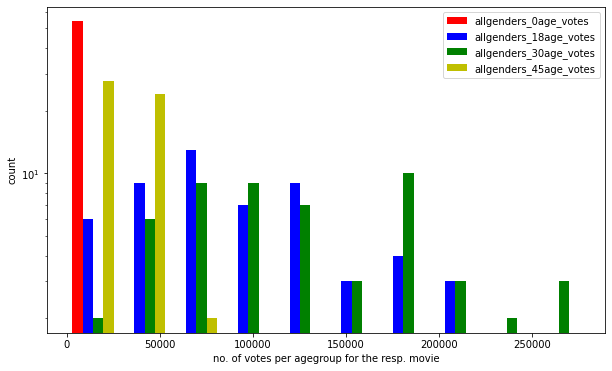

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
col_names = ['allgenders_0age_votes','allgenders_18age_votes','allgenders_30age_votes','allgenders_45age_votes']
ax.hist([our_movies[col_name] for col_name in col_names], color=['r','b', 'g', 'y'], log=True, label=col_names)
plt.legend()
plt.ylabel('count')
plt.xlabel('no. of votes per agegroup for the resp. movie');

In [55]:
mod = smf.ols(formula='mean_vote ~ allgenders_0age_avg_vote + allgenders_18age_avg_vote + allgenders_30age_avg_vote + allgenders_45age_avg_vote', data=relevant_years_stdz)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              mean_vote   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     3641.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:13:52   Log-Likelihood:                -23.888
No. Observations:                 969   AIC:                             57.78
Df Residuals:                     964   BIC:                             82.16
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

However, when taking a look at the linear regression model to predict the total mean of votes from the mean in each agegroup, it turns out that only 18-30 years old and 45 and older have a significant influence on the mean of all votes. While we would expect such a result for the (highly underrepresented, only 40k Votes in total) group of < 18 years old, we are very surprised that the group of 30-45 years old has no significant influence on the overall rating of the movie. 

<AxesSubplot:xlabel='allgenders_0age_avg_vote', ylabel='mean_vote'>

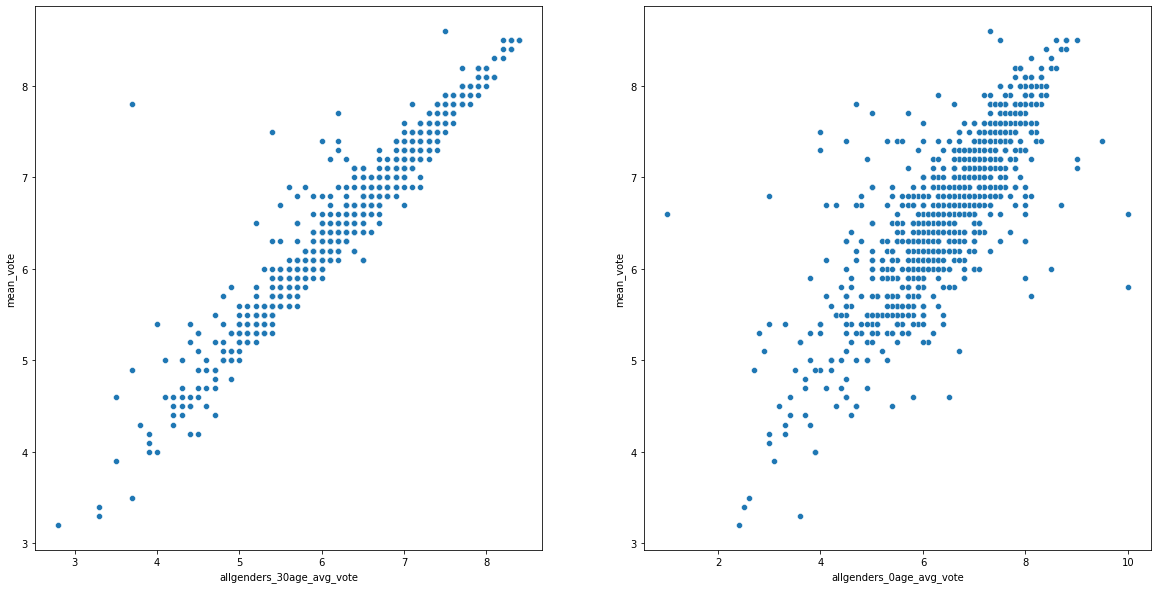

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
sns.scatterplot(x='allgenders_30age_avg_vote', y='mean_vote', data=relevant_years, ax=ax[0])
sns.scatterplot(x='allgenders_0age_avg_vote', y='mean_vote', data=relevant_years, ax=ax[1])

In [60]:
pearsonr(relevant_years['allgenders_30age_avg_vote'], relevant_years['mean_vote'])

(0.9606944531483329, 0.0)

In [61]:
pearsonr(relevant_years['allgenders_0age_avg_vote'].fillna(0), relevant_years['mean_vote'])

(0.6369770049233463, 4.0224777939818456e-114)

For these two groups, we further investigate their influence on the mean. For both, we get high values of pearson r, with a nearly 1 value for the group between 30 and 45. We might deduce the following: The group of 30-45 seems to be closely following the average vote, being about on the same level. However, high average means are only achieved when either 18-30 or 45+ ages vote good on movies, at least on average for single movies. 

---

# RQ5: The effect of COVID on media coverage of movies <a class="anchor" id="chapter5"></a>

## Proposed method: 
## 5.1. Calculate mean number of quotes on movies between 2015-2019 on a daily basis, calculate confidence intervals (bootstrapping), compare with 2020 data <a class="anchor" id="chapter51"></a>

In [50]:
def load_json(file):
    with open(file) as handle:
        data = json.load(handle)
    return data


In [54]:
quotes = df_Quotebank
top10_movies = load_json("./exploratory/data/rq1/top_10.json")

In [73]:
def count_quotes_by_movies(quotes, top10_movies):

    pre_covid_movies = top10_movies[str(2015)] + top10_movies[str(2016)] + top10_movies[str(2017)] + top10_movies[str(2018)] + top10_movies[str(2019)]

    covid_movies = top10_movies[str(2020)]

    all_quotes_by_date = []
    for movie in pre_covid_movies:
        df = quotes[quotes['movie'] == movie]['date']
        df = dict(Counter(df))
        df = OrderedDict(sorted(df.items(), key=lambda t: t[0]))
        all_quotes_by_date.append({f'{k.month}-{k.day}': v for k, v in df.items()})
      

    final = defaultdict(list)
    for dict_ in all_quotes_by_date:
        for k, v in dict_.items():
            final[k].append(v)

    covid_quotes_by_date = []
    for movie in covid_movies:
        df = quotes[quotes['movie'] == movie]['date']
        df = dict(Counter(df))
        df = OrderedDict(sorted(df.items(), key=lambda t: t[0]))
        covid_quotes_by_date.append({f'{k.month}-{k.day}': v for k, v in df.items()})


    covid_final = defaultdict(list)
    for dict_ in covid_quotes_by_date:
        for k, v in dict_.items():
            covid_final[k].append(v)

    return final, covid_final

def calculate_average_by_date(final, covid_final):
    averages = OrderedDict()
    covid_averages = OrderedDict()

    for k,v in final.items():
        averages[k] = np.array(v).mean()
        covid_averages[k] = 0
    
    for k,v in covid_final.items():
        covid_averages[k] = np.array(v).mean()

    return averages, covid_averages

In [74]:
final, covid_final = count_quotes_by_movies(quotes, top10_movies)
averages, covid_averages = calculate_average_by_date(final, covid_final)


2020 is a leap year, so we get rid of 29 of February

In [78]:
leap = covid_averages['2-29']
print(f'number of quotes on February 29: {leap}')
del covid_averages['2-29']

number of quotes on February 29: 3.0


In [79]:
#bootsrap confidence intervals
lens = []
for k,v in tqdm(final.items()):
    lens.append(len(v))
avg = sum(lens)/len(lens)
print(f'average number of movies being quoted: {avg}')

lower_bound = []
upper_bound = []
for k,v in tqdm(final.items()):
    if len(v) < int(avg):
        x = np.zeros(int(avg)) #padding with zeros if we have few observations
        x[:len(v)] = v
    l, u = bootstrap_CI(x, 1000)
    lower_bound.append(l)
    upper_bound.append(u)

  0%|          | 0/366 [00:00<?, ?it/s]

average number of movies being quoted: 25.415300546448087


  0%|          | 0/366 [00:00<?, ?it/s]

Text(0, 0.5, 'average number of quotes')

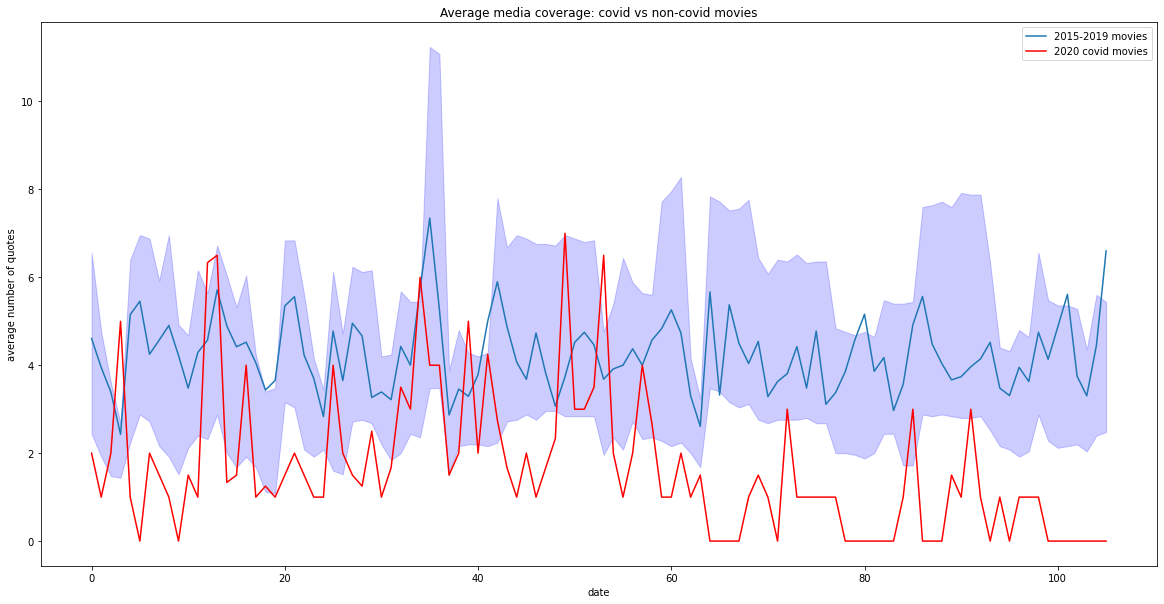

In [83]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_title('Average media coverage: covid vs non-covid movies')
plt.fill_between(np.arange(106), lower_bound[:106], upper_bound[:106], alpha=.2, color='blue')
sns.lineplot(np.arange(106), list(averages.values())[:106], ax=ax, label='2015-2019 movies')
sns.lineplot(np.arange(106), list(covid_averages.values())[:106], ax=ax, color='red', label='2020 covid movies')
ax.set_xlabel('date')
ax.set_ylabel('average number of quotes')

The plot suggests that from the beginning of march in 2020, movies were quoted less than in the years before. The red line is not in the confidence interval, so we can conclude the difference is significant. This means the covid pendemic had a negative effect on the news about movies.

---

## Proposed method:
## Use regression for comparison of the mean number of quotes across movies in covid and non-covid period, use t-test for comparison of means <a class="anchor" id="chapter52"></a>

We have to be extra careful in this task again, 2020 data is until 04-16, so in ored to make it comperable we will only consider quotes in this period between 2015-2019.

In [84]:
filtered = []

quotes['date'] = pd.to_datetime(quotes['date'])

#filtering quotes before 2020 to get quotes only before 04-16 (we only have data for this period in 2020)
for year in range(2015, 2020):
    value_to_check = pd.Timestamp(year, 4, 16)
    filter_mask = quotes['date'] < value_to_check
    filtered.append(quotes[filter_mask])

#filteirng quotes in 2020
value_to_check = pd.Timestamp(2019, 12, 31)  
filter_mask = quotes['date'] > value_to_check
filtered.append(quotes[filter_mask])
quotes_before_04_16 = pd.concat(filtered)

covid = movies_df.merge(quotes_before_04_16.groupby('movie').sum()['numOccurrences'],left_on='original_title', right_index=True) #merge quotes with movies
covid = covid[['original_title','year', 'numOccurrences']]
covid['year'] = covid['year'].astype(int)
covid = covid[covid['year']>2014]
covid['covid'] = 0
covid.loc[covid['year'] == 2020, 'covid'] = 1 #adding dummy variable whether a movie came out in 2020 or not (effected by the pandemic)

<AxesSubplot:xlabel='covid', ylabel='numOccurrences'>

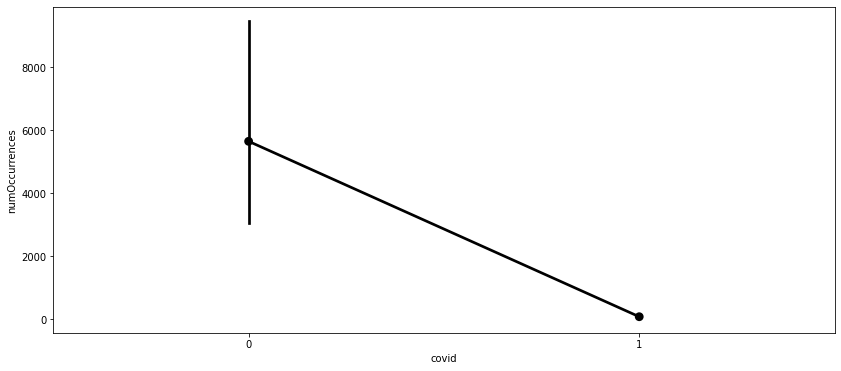

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(14,6))
sns.pointplot(x='covid', y='numOccurrences', data=covid, color='black', ax=ax)

The plot suggests that the difference is significant, the two dot represent the mean of the data and the lines are the bootstrapped confidence intervals, since the intervals do not overlap, the difference is significant. We can come to similar conclusion using linear regression

In [86]:
res = smf.ols(formula='numOccurrences ~ covid', data=covid).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         numOccurrences   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.186
Date:                Thu, 16 Dec 2021   Prob (F-statistic):              0.281
Time:                        21:54:19   Log-Likelihood:                -577.57
No. Observations:                  54   AIC:                             1159.
Df Residuals:                      52   BIC:                             1163.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5650.0204   1555.713      3.632      0.0

We can observe the following:
$$ \text{number of quotes} = 5450 - 5360 \times \text{covid}$$

From the regression we can see immediately see that the mean score for non-covid movies is the intercept ($2264 $), and adding the dummy indicator *covid*, we get the mean score for movies in 2020, which is $66$.